In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
%matplotlib inline

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)

In [2]:
# load data
items = pd.read_csv('E:/DOWLOAD/LightGBM_XGBoost/item1.csv')
train = pd.read_csv('E:/DOWLOAD/LightGBM_XGBoost/order1.csv')
test  = pd.read_csv('E:/DOWLOAD/LightGBM_XGBoost/data/test.csv')


In [3]:
train

,date,orders,clicks,product_id,campaign_id,price,purchase_price
0,2021-01-01,0,11,68202834,1,221204,171204
1,2021-01-01,0,20,176251118,1,293260,243260
2,2021-01-01,0,12,99325284,1,79385,74385
3,2021-01-01,0,19,99183754,1,165042,160042
4,2021-01-01,1,4,99156609,1,104577,99577
...,...,...,...,...,...,...,...
5223145,2023-12-31,0,14,273633499,48,4053000,4003000
5223146,2023-12-31,0,17,34573674,48,800000,750000
5223147,2023-12-31,2,11,34573146,48,800000,750000
5223148,2023-12-31,0,15,271392620,48,1199000,1149000


In [4]:
test

,product_id
0,68202834
1,176251118
2,99325284
3,99183754
4,99156609
...,...
1349,273633499
1350,34573674
1351,34573146
1352,271392620


In [5]:
# Chuyển đổi cột 'date' sang dạng datetime
train['date'] = pd.to_datetime(train['date'])

# Tạo cột 'date_block_num' dựa trên 'date'
train['date_block_num'] = (train['date'].dt.year - 2021) * 12 + train['date'].dt.month


In [6]:
train

,date,orders,clicks,product_id,campaign_id,price,purchase_price,date_block_num
0,2021-01-01,0,11,68202834,1,221204,171204,1
1,2021-01-01,0,20,176251118,1,293260,243260,1
2,2021-01-01,0,12,99325284,1,79385,74385,1
3,2021-01-01,0,19,99183754,1,165042,160042,1
4,2021-01-01,1,4,99156609,1,104577,99577,1
...,...,...,...,...,...,...,...,...
5223145,2023-12-31,0,14,273633499,48,4053000,4003000,36
5223146,2023-12-31,0,17,34573674,48,800000,750000,36
5223147,2023-12-31,2,11,34573146,48,800000,750000,36
5223148,2023-12-31,0,15,271392620,48,1199000,1149000,36


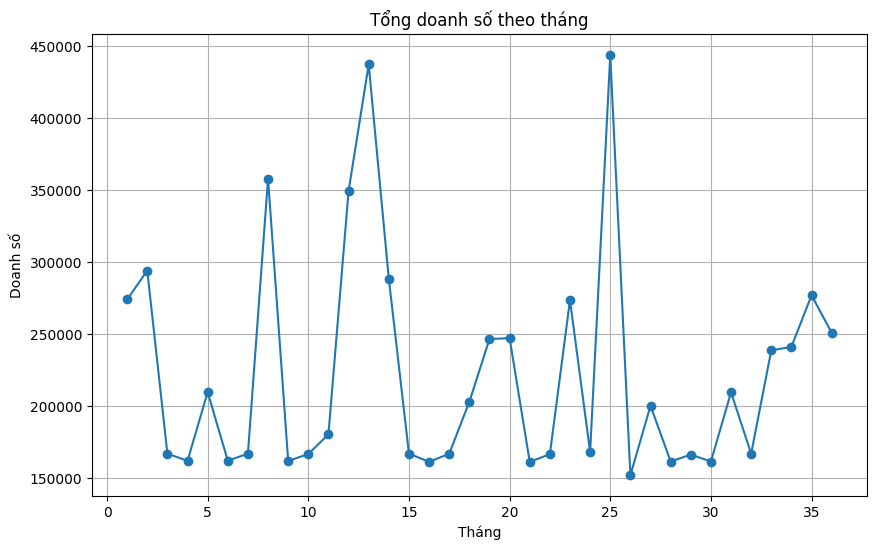

In [7]:
# Nhóm dữ liệu theo 'date_block_num' và tính tổng doanh số của mỗi tháng
sale_by_month = train.groupby('date_block_num')['orders'].sum()

# Vẽ biểu đồ
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(sale_by_month.index, sale_by_month.values, marker='o', linestyle='-')
plt.title('Tổng doanh số theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Doanh số')
plt.grid(True)
plt.show()


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_seasonal_decompose(result, title="Seasonal Decomposition"):
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.observed, mode="lines"),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.trend.index, y=result.trend, mode="lines"),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.seasonal, mode="lines"),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.resid.index, y=result.resid, mode="lines"),
            row=4,
            col=1,
        )
        .update_layout(
            height=900,
            title=title,
            margin=dict(t=100),
            title_x=0.5,
            showlegend=False
        )
    )

seasonnal = seasonal_decompose(sale_by_month, model='multiplicative', period=7)
plot_seasonal_decompose(seasonnal, title="Annual Seasonal Decomposition of Sales")


<Axes: ylabel='Frequency'>

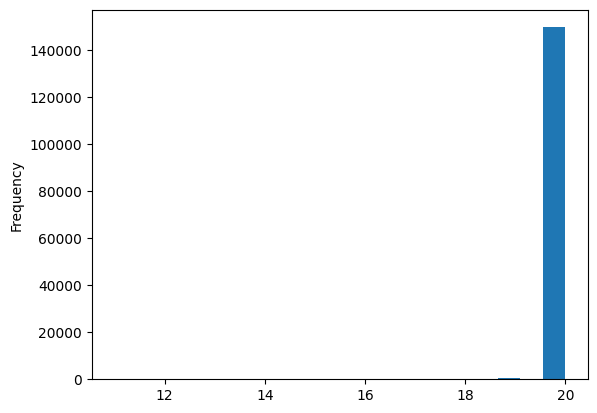

In [9]:
block_item_sale = train.groupby(['date_block_num','product_id','campaign_id'])['orders'].sum()
block_item_sale.clip(0,20).plot.hist(bins=20)

In [10]:
train['revenue'] = train['price'] -train['purchase_price']
train

,date,orders,clicks,product_id,campaign_id,price,purchase_price,date_block_num,revenue
0,2021-01-01,0,11,68202834,1,221204,171204,1,50000
1,2021-01-01,0,20,176251118,1,293260,243260,1,50000
2,2021-01-01,0,12,99325284,1,79385,74385,1,5000
3,2021-01-01,0,19,99183754,1,165042,160042,1,5000
4,2021-01-01,1,4,99156609,1,104577,99577,1,5000
...,...,...,...,...,...,...,...,...,...
5223145,2023-12-31,0,14,273633499,48,4053000,4003000,36,50000
5223146,2023-12-31,0,17,34573674,48,800000,750000,36,50000
5223147,2023-12-31,2,11,34573146,48,800000,750000,36,50000
5223148,2023-12-31,0,15,271392620,48,1199000,1149000,36,50000


In [11]:
train['profit'] = train['revenue']*train['orders']


group = train.groupby(['date_block_num','campaign_id','product_id']).agg({'orders': ['sum'], 'profit': ['sum']})

# Đặt lại tên cột kết quả
group.columns = ['item_cnt_month', 'profit_month']

group

# # Kết hợp DataFrame 'matrix' với DataFrame 'group' dựa trên các cột trong 'cols' và dùng phương pháp 'left join'
# matrix = matrix.merge(group, on=['date_block_num', 'campaign_id', 'product_id'], how='left')

ts = time.time()

# Đặt lại index của group
group = group.reset_index()
matrix=[]
# Tạo matrix từ group
matrix = group.copy()

# Chuyển đổi các cột về dạng số nguyên
matrix['date_block_num'] = matrix['date_block_num'].astype(int)
matrix['campaign_id'] = matrix['campaign_id'].astype(int)
matrix['product_id'] = matrix['product_id'].astype(int)

# Sắp xếp matrix theo các cột 'date_block_num', 'campaign_id', và 'product_id'
matrix.sort_values(['date_block_num', 'campaign_id', 'product_id'], inplace=True)

time.time() - ts



0.10415172576904297

In [12]:
matrix

,date_block_num,campaign_id,product_id,item_cnt_month,profit_month
0,1,1,42899542,85,425000
1,1,1,61393910,27,135000
2,1,1,68202834,97,4850000
3,1,1,73552136,28,140000
4,1,1,74421745,30,150000
...,...,...,...,...,...
150439,36,48,273386993,33,1650000
150440,36,48,273633499,29,1450000
150441,36,48,273847739,38,1900000
150442,36,48,274069973,28,1400000


In [13]:
matrix

,date_block_num,campaign_id,product_id,item_cnt_month,profit_month
0,1,1,42899542,85,425000
1,1,1,61393910,27,135000
2,1,1,68202834,97,4850000
3,1,1,73552136,28,140000
4,1,1,74421745,30,150000
...,...,...,...,...,...
150439,36,48,273386993,33,1650000
150440,36,48,273633499,29,1450000
150441,36,48,273847739,38,1900000
150442,36,48,274069973,28,1400000


In [14]:
for column in matrix.columns:
    print(f"Số lượng giá trị của cột '{column}':")
    print(matrix[column].value_counts())
    print()

Số lượng giá trị của cột 'date_block_num':
date_block_num
1     4179
2     4179
21    4179
22    4179
23    4179
24    4179
25    4179
26    4179
27    4179
28    4179
29    4179
30    4179
31    4179
32    4179
33    4179
34    4179
35    4179
20    4179
19    4179
18    4179
9     4179
3     4179
4     4179
5     4179
6     4179
7     4179
8     4179
10    4179
17    4179
11    4179
12    4179
13    4179
14    4179
15    4179
16    4179
36    4179
Name: count, dtype: int64

Số lượng giá trị của cột 'campaign_id':
campaign_id
22    11556
24    11556
23    11556
1      4104
2      4104
3      4104
45     3672
43     3672
44     3672
8      3564
9      3564
7      3564
4      3420
5      3420
6      3420
41     3312
40     3312
12     3312
11     3312
10     3312
42     3312
33     3096
32     3096
31     3096
27     3024
25     3024
26     3024
37     2952
39     2952
38     2952
34     2772
35     2772
36     2772
48     2592
47     2592
46     2592
17     1404
16     1404
18     1404

In [15]:
# Thực hiện phép nối giữa DataFrame 'matrix' và DataFrame 'items' dựa trên cột 'product_id' của 'matrix' và cột 'id' của 'items'
matrix = pd.merge(matrix, items, left_on=['product_id'], right_on=['id'], how='left')

# Xóa cột 'id' trong DataFrame 'matrix' nếu bạn không cần nó sau khi đã thực hiện phép nối
matrix.drop('id', axis=1, inplace=True)




In [16]:
matrix

,date_block_num,campaign_id,product_id,item_cnt_month,profit_month,name,short_description,categories_id,categories_name
0,1,1,42899542,85,425000,"Áo ba lỗ nam/ 3 lỗ nam cao cấp, sợi cotton mềm...",CHI TIẾT SẢN PHẨM. Áo Ba lỗ Tanktop MRM kiểu ...,10378,Áo thun nam ba lỗ
1,1,1,61393910,27,135000,Siêu giảm giá. Áo thun wash Nhật Bản thương hi...,Thông số áo thun (áo phông) wash GOKINGForm áo...,1685,Áo thun nam ngắn tay không cổ
2,1,1,68202834,97,4850000,"Combo 2 áo ba lỗ nam, áo sát nách nam,sợi cott...",KIỂU DÁNG: SLIM FITCHI TIẾT:- Áo Tanktop sá...,10378,Áo thun nam ba lỗ
3,1,1,73552136,28,140000,Áo thun nam tay lỡ form rộng Stay Real 69,Áo thun nam tay lỡ form rộng Stay Real 69Colo...,1685,Áo thun nam ngắn tay không cổ
4,1,1,74421745,30,150000,"Áo One Piece Zoro ATT-02, Áo thun Anime Manga ...","Áo One Piece Zoro ATT-02, áo thun One Piece Ro...",1685,Áo thun nam ngắn tay không cổ
...,...,...,...,...,...,...,...,...,...
150439,36,48,273386993,33,1650000,Giày Boots Nam chính hãng BXXY (879),Hàng chính hãng Thương hiệu: BXXY Nhà sản xuấ...,49642,Giày boots nam cổ thấp
150440,36,48,273633499,29,1450000,GIÀY BOOT ECCO NAM GRAINER M 21470401001 222,"Mang dáng vẻ mới mẻ, bộ sưu tập giày Boot ECCO...",49642,Giày boots nam cổ thấp
150441,36,48,273847739,38,1900000,Timberland Giày Nam Boot Cổ Trung Basic Chukka...,Thông tin thương hiệu: Timberland là một nhà s...,49642,Giày boots nam cổ thấp
150442,36,48,274069973,28,1400000,Giày Boots Nam GEOX U Spherica Ec1 C,• Đôi boot cổ thấp hiện đại dà...,49642,Giày boots nam cổ thấp


matrix

In [17]:
def lag_feature(df, lags, col):
    # Tạo một bản sao của DataFrame chỉ chứa các cột 'date_block_num', 'shop_id', 'item_id' và cột 'col'
    tmp = df[['date_block_num','campaign_id','product_id',col]]
    
    # Vòng lặp qua tất cả các độ trễ trong danh sách 'lags'
    for i in lags:
        # Tạo một bản sao của DataFrame 'tmp' để thêm cột độ trễ
        shifted = tmp.copy()
        
        # Đặt tên cho cột mới với độ trễ tương ứng
        shifted.columns = ['date_block_num','campaign_id','product_id', col+'_lag_'+str(i)]
        
        # Tăng giá trị 'date_block_num' của DataFrame 'shifted' lên 'i'
        shifted['date_block_num'] += i
        
        # Kết hợp DataFrame gốc 'df' với DataFrame 'shifted' dựa trên các cột 'date_block_num', 'shop_id', 'item_id' và phương thức 'left join'
        df = pd.merge(df, shifted, on=['date_block_num','campaign_id','product_id'], how='left')
    
    # Trả về DataFrame đã được mở rộng với các cột độ trễ
    return df


In [18]:

matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [19]:
def add_group_stats(matrix_, groupby_feats, target, enc_feat, last_periods):
    # Kiểm tra nếu 'date_block_num' không nằm trong các cột nhóm
    if not 'date_block_num' in groupby_feats:
        print ('date_block_num must in groupby_feats') # In thông báo lỗi
        return matrix_ # Trả về DataFrame ban đầu nếu có lỗi
    
    # Nhóm dữ liệu theo các cột nhóm 'groupby_feats' và tính tổng 'target' cho mỗi nhóm
    group = matrix_.groupby(groupby_feats)[target].sum().reset_index()
    
    # Xác định số lượng lớn nhất của độ trễ trong 'last_periods'
    max_lags = np.max(last_periods)
    
    # Vòng lặp qua tất cả các độ trễ từ 1 đến 'max_lags'
    for i in range(1,max_lags+1):
        # Tạo bản sao của nhóm dữ liệu và tăng giá trị 'date_block_num' lên 'i'
        shifted = group[groupby_feats+[target]].copy(deep=True)
        shifted['date_block_num'] += i
        
        # Đổi tên cột 'target' thành 'target+'_lag_'+str(i)'
        shifted.rename({target:target+'_lag_'+str(i)},axis=1,inplace=True)
        
        # Kết hợp DataFrame 'group' với DataFrame 'shifted' dựa trên các cột nhóm và phương thức 'left join'
        group = group.merge(shifted, on=groupby_feats, how='left')
    
    # Thay thế giá trị NaN bằng 0
    group.fillna(0,inplace=True)
    
    # Vòng lặp qua các khoảng thời gian 'last_periods'
    for period in last_periods:
        lag_feats = [target+'_lag_'+str(lag) for lag in np.arange(1,period+1)]
        
        # Tính trung bình và bình phương trung bình của 'lag_feats'
        mean = group[lag_feats].sum(axis=1)/float(period)
        mean2 = (group[lag_feats]**2).sum(axis=1)/float(period)
        
        # Tạo các cột mới chứa giá trị trung bình và độ lệch chuẩn
        group[enc_feat+'_avg_sale_last_'+str(period)] = mean
        group[enc_feat+'_std_sale_last_'+str(period)] = (mean2 - mean**2).apply(np.sqrt)
        
        # Thay thế giá trị vô hướng bằng 0
        group[enc_feat+'_std_sale_last_'+str(period)].replace(np.inf,0,inplace=True)
        
        # Chia cho giá trị trung bình của mỗi cột, điều này làm cho các đặc trưng có tỷ lệ giống nhau cho mạng nơ-ron
        group[enc_feat+'_avg_sale_last_'+str(period)] /= group[enc_feat+'_avg_sale_last_'+str(period)].mean()
        group[enc_feat+'_std_sale_last_'+str(period)] /= group[enc_feat+'_std_sale_last_'+str(period)].mean()
    
    # Tạo danh sách cột mới cần thêm vào 'matrix_'
    cols = groupby_feats + [f_ for f_ in group.columns.values if f_.find('_sale_last_')>=0]
    
    # Kết hợp DataFrame 'matrix_' với các cột mới từ DataFrame 'group' dựa trên các cột nhóm và phương thức 'left join'
    matrix = matrix_.merge(group[cols], on=groupby_feats, how='left')
    
    # Trả về DataFrame đã được mở rộng với các cột mới
    return matrix


In [20]:
ts = time.time()
matrix = add_group_stats(matrix, ['date_block_num', 'product_id'], 'item_cnt_month', 'product', [6,12])
matrix = add_group_stats(matrix, ['date_block_num', 'campaign_id'], 'item_cnt_month', 'campaign', [6,12])
matrix = add_group_stats(matrix, ['date_block_num', 'categories_id'], 'item_cnt_month', 'category', [12])
time.time() - ts

1.3395824432373047

In [21]:
def target_encoding(matrix_, groupby_feats, target, enc_feat, lags):
    # In ra thông báo về việc sử dụng target encoding cho các nhóm được chỉ định
    print ('target encoding for',groupby_feats)
    
    # Nhóm dữ liệu theo các cột nhóm và tính trung bình của 'target' cho mỗi nhóm
    group = matrix_.groupby(groupby_feats).agg({target:'mean'})
    
    # Đặt tên cho cột kết quả là 'enc_feat'
    group.columns = [enc_feat]
    
    # Đặt lại chỉ số của DataFrame 'group' và kết hợp nó với DataFrame gốc 'matrix_'
    group.reset_index(inplace=True)
    matrix = matrix_.merge(group, on=groupby_feats, how='left')
    
    # Chuyển đổi kiểu dữ liệu của cột 'enc_feat' thành np.float16
    matrix[enc_feat] = matrix[enc_feat].astype(np.float16)
    
    # Tạo các đặc trưng độ trễ từ đặc trưng đã được mã hóa mục tiêu
    matrix = lag_feature(matrix, lags, enc_feat)
    
    # Loại bỏ cột mã hóa mục tiêu đã được tạo ra từ 'matrix_'
    matrix.drop(enc_feat, axis=1, inplace=True)
    
    # Trả về DataFrame 'matrix_' đã được mở rộng với các đặc trưng độ trễ từ mã hóa mục tiêu
    return matrix


In [22]:
ts = time.time()
matrix = target_encoding(matrix, ['date_block_num'], 'item_cnt_month', 'date_avg_item_cnt', [1])
matrix = target_encoding(matrix, ['date_block_num', 'campaign_id'], 'item_cnt_month', 'date_campaign_avg_item_cnt', [1,2,3,6,12])
matrix = target_encoding(matrix, ['date_block_num', 'product_id'], 'item_cnt_month', 'date_item_avg_item_cnt', [1,2,3,6,12])
matrix = target_encoding(matrix, ['date_block_num', 'campaign_id', 'categories_id'], 'item_cnt_month', 'date_campaign_cat_avg_item_cnt', [1])

time.time() - ts

target encoding for ['date_block_num']
target encoding for ['date_block_num', 'campaign_id']
target encoding for ['date_block_num', 'product_id']
target encoding for ['date_block_num', 'campaign_id', 'categories_id']


2.516470193862915

In [23]:
import pandas as pd
import numpy as np
import time

# Lấy thời gian bắt đầu tính toán
ts = time.time()

# Tính giá trung bình của mỗi mặt hàng và gán vào cột mới 'item_avg_item_price'
group = train.groupby(['product_id']).agg({'price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

# Kết hợp DataFrame 'matrix' với DataFrame 'group' dựa trên cột 'item_id'
matrix = pd.merge(matrix, group, on=['product_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# Tính giá trung bình của mỗi mặt hàng theo tháng và gán vào cột mới 'date_item_avg_item_price'
group = train.groupby(['date_block_num','product_id']).agg({'price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

# Kết hợp DataFrame 'matrix' với DataFrame 'group' dựa trên các cột 'date_block_num' và 'item_id'
matrix = pd.merge(matrix, group, on=['date_block_num','product_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

# Xác định các độ trễ cần sử dụng
lags = [1,2,3,4,5,6]

# Tạo các đặc trưng độ trễ từ cột 'date_item_avg_item_price' sử dụng các độ trễ trong 'lags'
for lag in lags:
    matrix['date_item_avg_item_price_lag_'+str(lag)] = matrix.groupby(['product_id'])['date_item_avg_item_price'].shift(lag)

# Tính toán biến thể giá so với giá trung bình của mỗi mặt hàng và gán vào các cột 'delta_price_lag_i'
for lag in lags:
    matrix['delta_price_lag_'+str(lag)] = \
        (matrix['date_item_avg_item_price_lag_'+str(lag)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# Lựa chọn xu hướng giá mới nhất từ các cột 'delta_price_lag_i'
def select_trend(row):
    for lag in lags:
        if pd.notna(row['delta_price_lag_'+str(lag)]):
            return row['delta_price_lag_'+str(lag)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# Loại bỏ các cột không cần thiết đã tạo ra
features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for lag in lags:
    features_to_drop += ['date_item_avg_item_price_lag_'+str(lag)]
    features_to_drop += ['delta_price_lag_'+str(lag)]

matrix.drop(features_to_drop, axis=1, inplace=True)

# Tính thời gian tính toán
time.time() - ts


10.446274280548096

In [24]:
# Lấy thời gian bắt đầu tính toán
ts = time.time()

# Tính tổng doanh thu của mỗi cửa hàng theo tháng và gán vào cột mới 'date_shop_revenue'
group = train.groupby(['date_block_num','campaign_id']).agg({'revenue': ['sum']})
group.columns = ['date_campaign_revenue']
group.reset_index(inplace=True)

# Kết hợp DataFrame 'matrix' với DataFrame 'group' dựa trên các cột 'date_block_num' và 'shop_id'
matrix = pd.merge(matrix, group, on=['date_block_num','campaign_id'], how='left')
matrix['date_campaign_revenue'] = matrix['date_campaign_revenue'].astype(np.float32)

# Tính giá trị trung bình của doanh thu của mỗi cửa hàng và gán vào cột mới 'shop_avg_revenue'
group = group.groupby(['campaign_id']).agg({'date_campaign_revenue': ['mean']})
group.columns = ['campaign_avg_revenue']
group.reset_index(inplace=True)

# Kết hợp DataFrame 'matrix' với DataFrame 'group' dựa trên cột 'shop_id'
matrix = pd.merge(matrix, group, on=['campaign_id'], how='left')
matrix['campaign_avg_revenue'] = matrix['campaign_avg_revenue'].astype(np.float32)

# Tính toán biến thể của doanh thu so với giá trị trung bình của mỗi cửa hàng và gán vào cột mới 'delta_revenue'
matrix['delta_revenue'] = (matrix['date_campaign_revenue'] - matrix['campaign_avg_revenue']) / matrix['campaign_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

# Tạo đặc trưng độ trễ từ cột 'delta_revenue' sử dụng độ trễ là 1
matrix = lag_feature(matrix, [1], 'delta_revenue')

# Loại bỏ các cột không cần thiết đã tạo ra
matrix.drop(['date_campaign_revenue','campaign_avg_revenue','delta_revenue'], axis=1, inplace=True)

# Tính thời gian tính toán
time.time() - ts


1.1299242973327637

In [25]:
matrix['month'] = matrix['date_block_num'] % 12
matrix['year'] = (matrix['date_block_num'] / 12).astype(np.int8)

In [26]:
# Khởi tạo một dataframe rỗng để lưu trữ thông tin về lần bán hàng cuối cùng của mỗi cặp cửa hàng / sản phẩm.
last_sale = pd.DataFrame()

# Duyệt qua các tháng từ 1 đến 36.
for month in range(1,37):
    # Tạo một dataframe last_month bằng cách lấy ra tháng lớn nhất mà sản phẩm đã được bán trong tháng đó cho mỗi cặp cửa hàng / sản phẩm trước tháng hiện tại.
    last_month = matrix.loc[(matrix['date_block_num']<month)&(matrix['item_cnt_month']>0)].groupby(['product_id','campaign_id'])['date_block_num'].max()
    
    # Tạo một dataframe df từ thông tin về tháng hiện tại, id sản phẩm, id cửa hàng và số tháng kể từ lần bán hàng cuối cùng.
    df = pd.DataFrame({
        'date_block_num':np.ones([last_month.shape[0],])*month,
        'product_id': last_month.index.get_level_values(0).values,
        'campaign_id': last_month.index.get_level_values(1).values,
        'item_campaign_last_sale': last_month.values
    })
    
    # Gộp dataframe df vào dataframe last_sale.
    last_sale = pd.concat([last_sale, df], ignore_index=True)

last_sale['date_block_num'] = last_sale['date_block_num'].astype(np.int32)

# Ghép dataframe last_sale vào dataframe matrix dựa trên các cột 'date_block_num', 'item_id', và 'shop_id' với phương pháp gộp 'left'.
matrix = matrix.merge(last_sale, on=['date_block_num','product_id','campaign_id'], how='left')


In [27]:
# Tính số tháng kể từ lần bán hàng cuối cùng cho mỗi sản phẩm.
ts = time.time()

# Khởi tạo một dataframe rỗng để lưu trữ thông tin về lần bán hàng cuối cùng của mỗi sản phẩm.
last_sale = pd.DataFrame()

# Duyệt qua các tháng từ 1 đến 36.
for month in range(1, 37):
    # Tạo một dataframe last_month bằng cách lấy ra tháng lớn nhất mà sản phẩm đã được bán trong tháng đó cho mỗi sản phẩm trước tháng hiện tại.
    last_month = matrix.loc[(matrix['date_block_num'] < month) & (matrix['item_cnt_month'] > 0)].groupby('product_id')['date_block_num'].max()
    
    # Tạo một dataframe df từ thông tin về tháng hiện tại, id sản phẩm và số tháng kể từ lần bán hàng cuối cùng của sản phẩm.
    df = pd.DataFrame({
        'date_block_num': np.ones([last_month.shape[0],])*month,
        'product_id': last_month.index.values,
        'item_last_sale': last_month.values
    })
    
    # Gộp dataframe df vào dataframe last_sale.
    last_sale = pd.concat([last_sale, df], ignore_index=True)

# Chuyển đổi kiểu dữ liệu cột date_block_num của dataframe last_sale sang kiểu dữ liệu số nguyên nhỏ để tiết kiệm bộ nhớ.
last_sale['date_block_num'] = last_sale['date_block_num'].astype(np.int32)

# Ghép dataframe last_sale vào dataframe matrix dựa trên các cột 'date_block_num' và 'item_id' với phương pháp gộp 'left'.
matrix = matrix.merge(last_sale, on=['date_block_num', 'product_id'], how='left')

# Tính thời gian thực thi của đoạn mã.
time.time() - ts


2.3615472316741943

In [28]:
# Months since the first sale for each shop/item pair and for item only.
ts = time.time()
matrix['item_campaign_first_sale'] = matrix['date_block_num'] - matrix.groupby(['product_id','campaign_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('product_id')['date_block_num'].transform('min')
time.time() - ts

0.05155348777770996

In [29]:
# matrix = matrix[matrix.date_block_num > 11]
matrix.columns

Index(['date_block_num', 'campaign_id', 'product_id', 'item_cnt_month',
       'profit_month', 'name', 'short_description', 'categories_id',
       'categories_name', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'product_avg_sale_last_6', 'product_std_sale_last_6',
       'product_avg_sale_last_12', 'product_std_sale_last_12',
       'campaign_avg_sale_last_6', 'campaign_std_sale_last_6',
       'campaign_avg_sale_last_12', 'campaign_std_sale_last_12',
       'category_avg_sale_last_12', 'category_std_sale_last_12',
       'date_avg_item_cnt_lag_1', 'date_campaign_avg_item_cnt_lag_1',
       'date_campaign_avg_item_cnt_lag_2', 'date_campaign_avg_item_cnt_lag_3',
       'date_campaign_avg_item_cnt_lag_6', 'date_campaign_avg_item_cnt_lag_12',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item

In [30]:
matrix.to_pickle('data.pkl')

In [31]:
data = pd.read_pickle('./data.pkl')
data.head()

,date_block_num,campaign_id,product_id,item_cnt_month,profit_month,name,short_description,categories_id,categories_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,product_avg_sale_last_6,product_std_sale_last_6,product_avg_sale_last_12,product_std_sale_last_12,campaign_avg_sale_last_6,campaign_std_sale_last_6,campaign_avg_sale_last_12,campaign_std_sale_last_12,category_avg_sale_last_12,category_std_sale_last_12,date_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_2,date_campaign_avg_item_cnt_lag_3,date_campaign_avg_item_cnt_lag_6,date_campaign_avg_item_cnt_lag_12,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_campaign_cat_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_campaign_last_sale,item_last_sale,item_campaign_first_sale,item_first_sale
0,1,1,42899542,85,425000,"Áo ba lỗ nam/ 3 lỗ nam cao cấp, sợi cotton mềm...",CHI TIẾT SẢN PHẨM. Áo Ba lỗ Tanktop MRM kiểu ...,10378,Áo thun nam ba lỗ,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,NaN,0,0
1,1,1,61393910,27,135000,Siêu giảm giá. Áo thun wash Nhật Bản thương hi...,Thông số áo thun (áo phông) wash GOKINGForm áo...,1685,Áo thun nam ngắn tay không cổ,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,NaN,0,0
2,1,1,68202834,97,4850000,"Combo 2 áo ba lỗ nam, áo sát nách nam,sợi cott...",KIỂU DÁNG: SLIM FITCHI TIẾT:- Áo Tanktop sá...,10378,Áo thun nam ba lỗ,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,NaN,0,0
3,1,1,73552136,28,140000,Áo thun nam tay lỡ form rộng Stay Real 69,Áo thun nam tay lỡ form rộng Stay Real 69Colo...,1685,Áo thun nam ngắn tay không cổ,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,NaN,0,0
4,1,1,74421745,30,150000,"Áo One Piece Zoro ATT-02, Áo thun Anime Manga ...","Áo One Piece Zoro ATT-02, áo thun One Piece Ro...",1685,Áo thun nam ngắn tay không cổ,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,NaN,0,0


In [32]:
# Xóa hai cột 'date_shop_avg_item_cnt_lag_12' và 'item_campaign_last_sale' từ DataFrame
data.drop(['item_campaign_last_sale','item_cnt_month_lag_12','date_campaign_avg_item_cnt_lag_12','date_item_avg_item_cnt_lag_12'], axis=1, inplace=True)
data.head()


,date_block_num,campaign_id,product_id,item_cnt_month,profit_month,name,short_description,categories_id,categories_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,product_avg_sale_last_6,product_std_sale_last_6,product_avg_sale_last_12,product_std_sale_last_12,campaign_avg_sale_last_6,campaign_std_sale_last_6,campaign_avg_sale_last_12,campaign_std_sale_last_12,category_avg_sale_last_12,category_std_sale_last_12,date_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_2,date_campaign_avg_item_cnt_lag_3,date_campaign_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_campaign_cat_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_last_sale,item_campaign_first_sale,item_first_sale
0,1,1,42899542,85,425000,"Áo ba lỗ nam/ 3 lỗ nam cao cấp, sợi cotton mềm...",CHI TIẾT SẢN PHẨM. Áo Ba lỗ Tanktop MRM kiểu ...,10378,Áo thun nam ba lỗ,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,0,0
1,1,1,61393910,27,135000,Siêu giảm giá. Áo thun wash Nhật Bản thương hi...,Thông số áo thun (áo phông) wash GOKINGForm áo...,1685,Áo thun nam ngắn tay không cổ,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,0,0
2,1,1,68202834,97,4850000,"Combo 2 áo ba lỗ nam, áo sát nách nam,sợi cott...",KIỂU DÁNG: SLIM FITCHI TIẾT:- Áo Tanktop sá...,10378,Áo thun nam ba lỗ,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,0,0
3,1,1,73552136,28,140000,Áo thun nam tay lỡ form rộng Stay Real 69,Áo thun nam tay lỡ form rộng Stay Real 69Colo...,1685,Áo thun nam ngắn tay không cổ,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,0,0
4,1,1,74421745,30,150000,"Áo One Piece Zoro ATT-02, Áo thun Anime Manga ...","Áo One Piece Zoro ATT-02, áo thun One Piece Ro...",1685,Áo thun nam ngắn tay không cổ,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0,NaN,0,0


In [33]:
for column in data.columns:
    print(f"Số lượng giá trị của cột '{column}':")
    print(data[column].value_counts())
    print()

Số lượng giá trị của cột 'date_block_num':
date_block_num
1     4179
2     4179
21    4179
22    4179
23    4179
24    4179
25    4179
26    4179
27    4179
28    4179
29    4179
30    4179
31    4179
32    4179
33    4179
34    4179
35    4179
20    4179
19    4179
18    4179
9     4179
3     4179
4     4179
5     4179
6     4179
7     4179
8     4179
10    4179
17    4179
11    4179
12    4179
13    4179
14    4179
15    4179
16    4179
36    4179
Name: count, dtype: int64

Số lượng giá trị của cột 'campaign_id':
campaign_id
22    11556
24    11556
23    11556
1      4104
2      4104
3      4104
45     3672
43     3672
44     3672
8      3564
9      3564
7      3564
4      3420
5      3420
6      3420
41     3312
40     3312
12     3312
11     3312
10     3312
42     3312
33     3096
32     3096
31     3096
27     3024
25     3024
26     3024
37     2952
39     2952
38     2952
34     2772
35     2772
36     2772
48     2592
47     2592
46     2592
17     1404
16     1404
18     1404

item_cnt_month_lag_6
30.0     7325
31.0     7292
29.0     6889
32.0     6865
28.0     6428
33.0     6215
27.0     5721
34.0     5478
26.0     4616
35.0     4597
25.0     3775
36.0     3470
24.0     2846
37.0     2796
23.0     2048
38.0     1974
39.0     1453
22.0     1402
40.0     1000
63.0      983
58.0      968
60.0      963
61.0      953
62.0      951
21.0      950
59.0      914
57.0      894
64.0      845
56.0      838
65.0      811
55.0      770
54.0      735
67.0      734
66.0      726
53.0      641
41.0      634
68.0      617
52.0      576
20.0      556
69.0      546
51.0      527
50.0      512
42.0      464
70.0      425
49.0      422
48.0      419
71.0      395
134.0     374
43.0      365
138.0     343
47.0      343
127.0     340
129.0     335
46.0      335
128.0     334
19.0      332
132.0     332
130.0     331
137.0     330
131.0     330
142.0     329
136.0     328
133.0     327
44.0      327
141.0     323
139.0     321
140.0     315
72.0      309
124.0     306
126.0     305

date_item_avg_item_cnt_lag_1
30.000000     4860
30.328125     4692
31.000000     4689
30.671875     4665
29.328125     4491
              ... 
252.375000       3
286.250000       3
169.000000       3
313.250000       3
283.750000       3
Name: count, Length: 830, dtype: int64

Số lượng giá trị của cột 'date_item_avg_item_cnt_lag_2':
date_item_avg_item_cnt_lag_2
30.000000     4740
31.000000     4590
30.328125     4578
30.671875     4557
31.328125     4386
              ... 
286.250000       3
169.000000       3
313.250000       3
262.750000       3
176.625000       3
Name: count, Length: 823, dtype: int64

Số lượng giá trị của cột 'date_item_avg_item_cnt_lag_3':
date_item_avg_item_cnt_lag_3
30.000000     4644
30.328125     4473
31.000000     4449
30.671875     4398
31.328125     4251
              ... 
178.375000       3
18.328125        3
264.750000       3
358.250000       3
373.750000       3
Name: count, Length: 814, dtype: int64

Số lượng giá trị của cột 'date_item_avg_item_cnt_lag

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150444 entries, 0 to 150443
Data columns (total 40 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   date_block_num                        150444 non-null  int32  
 1   campaign_id                           150444 non-null  int32  
 2   product_id                            150444 non-null  int32  
 3   item_cnt_month                        150444 non-null  int64  
 4   profit_month                          150444 non-null  int64  
 5   name                                  150444 non-null  object 
 6   short_description                     150444 non-null  object 
 7   categories_id                         150444 non-null  int64  
 8   categories_name                       150444 non-null  object 
 9   item_cnt_month_lag_1                  146265 non-null  float64
 10  item_cnt_month_lag_2                  142086 non-null  float64
 11  

In [35]:
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Áp dụng LabelEncoder cho từng trường dữ liệu cần được mã hóa
for column in ['name', 'short_description', 'categories_name']:
    data[column] = label_encoder.fit_transform(data[column])
# Xác định cột chứa giá trị NaN hoặc inf trong X_train
invalid_columns = np.unique(np.where(~np.isfinite(data))[1])
invalid_column_names = data.columns[invalid_columns]
# Chuyển các cột sang dạng số
data[invalid_column_names] = data[invalid_column_names].astype(float)



In [36]:
# Chuyển các giá trị inf thành nan
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Thay thế các giá trị nan bằng giá trị trung bình của cột tương ứng
data.fillna(data.mean(), inplace=True)

In [37]:
X_train = data[data.date_block_num < 25].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 25]['item_cnt_month']
X_valid = data[data.date_block_num == 25].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 25]['item_cnt_month']
X_test = data[data.date_block_num == 26].drop(['item_cnt_month'], axis=1)
Y_test01 = data[data.date_block_num == 26]['item_cnt_month']

gc.collect();

In [38]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)

In [39]:


# Tiếp tục với việc xử lý dữ liệu và huấn luyện mô hình


In [40]:
# Xác định các đặc trưng phân loại trong dữ liệu
cat_feats = [feat for feat in X_train.columns if 'cat' in feat]

# Định nghĩa các tham số của mô hình
params = {
    'max_depth': 8,
    'n_estimators': 500,
    'colsample_bytree': 0.7,
    'min_child_weight': 300,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 42,
    'verbose': 10  # Set verbosity level here
}

# Khởi tạo mô hình LightGBM
model = LGBMRegressor(**params)

# Huấn luyện mô hình
ts = time.time()
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    categorical_feature=cat_feats,
)
time.time() - ts


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.069687
[LightGBM] [Debug] init for col-wise cost 0.000031 seconds, init for row-wise cost 0.031754 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7104
[LightGBM] [Info] Number of data points in the train set: 100296, number of used features: 39
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Ligh

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 8
[LightGBM] [Warning] No further splits w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No furthe

8.951027870178223

In [41]:
# Dự đoán kết quả trên tập dữ liệu validation và giới hạn giá trị trong khoảng từ 0 đến 20
Y_pred = model.predict(X_valid)

# Dự đoán kết quả trên tập dữ liệu test và giới hạn giá trị trong khoảng từ 0 đến 20
Y_test = model.predict(X_test)

# Tạo DataFrame cho kết quả dự đoán trên tập dữ liệu validation và lưu vào file CSV
X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]),  # Tạo cột ID từ 0 đến số lượng mẫu dự đoán trên tập validation
    "item_cnt_month": Y_pred  # Kết quả dự đoán trên tập validation
})
X_train_level2.to_csv('lgb_valid.csv', index=False)  # Lưu DataFrame vào file CSV

# Tạo DataFrame cho kết quả dự đoán trên tập dữ liệu test và lưu vào file CSV
submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]),  # Tạo cột ID từ 0 đến số lượng mẫu dự đoán trên tập test
    "item_cnt_month": Y_test  # Kết quả dự đoán trên tập test
})
submission.to_csv('lgb_submission.csv', index=False)  # Lưu DataFrame vào file CSV


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [42]:
import numpy as np

# Kiểm tra dữ liệu của mảng X_train
invalid_indices = np.where(~np.isfinite(X_train))

# In ra chỉ mục của các giá trị không hợp lệ
print("Chỉ mục của các giá trị không hợp lệ trong X_train:", invalid_indices)


Chỉ mục của các giá trị không hợp lệ trong X_train: (array([], dtype=int64), array([], dtype=int64))


In [43]:
# Chuyển các giá trị inf thành nan
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Thay thế các giá trị nan bằng giá trị trung bình của cột tương ứng
X_train.fillna(X_train.mean(), inplace=True)

In [44]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import time
import sys
import gc
import pickle
sys.version_info
# Đo thời gian bắt đầu thực thi của đoạn mã.
ts = time.time()

# Khởi tạo mô hình XGBoost Regressor với các tham số đã được cấu hình trước.
model = XGBRegressor(
    max_depth=7,                # Độ sâu tối đa của cây
    n_estimators=1000,          # Số lượng cây trong mô hình
    min_child_weight=300,       # Trọng số tối thiểu của mỗi nút lá
    colsample_bytree=0.8,       # Tỉ lệ số cột được sử dụng cho mỗi cây
    subsample=0.8,              # Tỉ lệ số mẫu được sử dụng cho mỗi cây
    gamma=0.005,                # Giảm số lượng các nút sau mỗi bước phát triển
    eta=0.1,                    # Tốc độ học của mô hình
    seed=42                     # Seed cho random state
)

# Huấn luyện mô hình XGBoost với dữ liệu huấn luyện và đánh giá trên tập validation.
model.fit(
    X_train,                                # Dữ liệu huấn luyện
    Y_train,                                # Nhãn của dữ liệu huấn luyện
    eval_metric="rmse",                     # Đánh giá mô hình bằng Root Mean Squared Error (RMSE)
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],  # Sử dụng tập huấn luyện và tập validation để đánh giá
    verbose=10,                             # Hiển thị thông tin về quá trình huấn luyện sau mỗi lượt huấn luyện
    early_stopping_rounds=40                # Dừng sớm quá trình huấn luyện nếu không có sự cải thiện trong 40 vòng lặp liên tiếp trên tập validation
)

# Tính và in ra thời gian thực thi của đoạn mã.
time.time() - ts


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-rmse:64.65817	validation_1-rmse:119.88065
[10]	validation_0-rmse:27.51665	validation_1-rmse:58.15283
[20]	validation_0-rmse:16.93199	validation_1-rmse:40.71232
[30]	validation_0-rmse:14.12948	validation_1-rmse:35.55036
[40]	validation_0-rmse:13.30389	validation_1-rmse:33.77297
[50]	validation_0-rmse:12.63334	validation_1-rmse:32.38466
[60]	validation_0-rmse:12.22759	validation_1-rmse:32.02207
[70]	validation_0-rmse:11.78597	validation_1-rmse:31.55808
[80]	validation_0-rmse:11.54885	validation_1-rmse:31.37524
[90]	validation_0-rmse:11.02913	validation_1-rmse:30.66671
[100]	validation_0-rmse:10.62778	validation_1-rmse:30.47524
[110]	validation_0-rmse:10.26341	validation_1-rmse:30.39639
[120]	validation_0-rmse:9.95449	validation_1-rmse:30.11321
[130]	validation_0-rmse:9.66775	validation_1-rmse:29.86210
[140]	validation_0-rmse:9.42230	validation_1-rmse:29.68614
[150]	validation_0-rmse:9.15232	validation_1-rmse:29.70993
[160]	validation_0-rmse:8.90444	validation_1-rmse:29.5

31.11213779449463

In [45]:
# Liệt kê các cột trong X_train và X_test
print("Columns in X_train:", X_train.columns)
print("Columns in X_test:", X_test.columns)

Columns in X_train: Index(['date_block_num', 'campaign_id', 'product_id', 'profit_month', 'name',
       'short_description', 'categories_id', 'categories_name',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'product_avg_sale_last_6',
       'product_std_sale_last_6', 'product_avg_sale_last_12',
       'product_std_sale_last_12', 'campaign_avg_sale_last_6',
       'campaign_std_sale_last_6', 'campaign_avg_sale_last_12',
       'campaign_std_sale_last_12', 'category_avg_sale_last_12',
       'category_std_sale_last_12', 'date_avg_item_cnt_lag_1',
       'date_campaign_avg_item_cnt_lag_1', 'date_campaign_avg_item_cnt_lag_2',
       'date_campaign_avg_item_cnt_lag_3', 'date_campaign_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_campaign_cat_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_reve

In [46]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import KFold
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error
# from lightgbm import early_stopping

# # Định nghĩa mô hình LightGBM và XGBoost
# params_lgb = {
#     'max_depth': 8,
#     'n_estimators': 500,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 300,
#     'reg_alpha': 0.1,
#     'reg_lambda': 1,
#     'random_state': 42,
#     'verbosity': 1  # Cấu hình đúng cho LightGBM là verbosity
# }

# params_xgb = {
#     'max_depth': 7,
#     'n_estimators': 1000,
#     'min_child_weight': 300,
#     'colsample_bytree': 0.8,
#     'subsample': 0.8,
#     'gamma': 0.005,
#     'learning_rate': 0.1,
#     'seed': 42,
#     'verbosity': 1  # Thêm verbosity cho XGBoost
# }

# # Khởi tạo K-Fold cross-validation
# n_folds = 5
# kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# # Chuẩn bị mảng để lưu trữ dự đoán cho tập valid và test
# valid_preds_lgb = np.zeros(X_valid.shape[0])
# valid_preds_xgb = np.zeros(X_valid.shape[0])
# test_preds_lgb = np.zeros(X_test.shape[0])
# test_preds_xgb = np.zeros(X_test.shape[0])

# # Huấn luyện mô hình và tạo dự đoán cho tập valid và test
# for train_index, valid_index in kf.split(X_train):
#     X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
#     y_tr, y_val = Y_train.iloc[train_index], Y_train.iloc[valid_index]

#     # LightGBM
#     model_lgb = LGBMRegressor(**params_lgb)
#     model_lgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])
#     valid_preds_lgb += model_lgb.predict(X_valid) / n_folds
#     test_preds_lgb += model_lgb.predict(X_test) / n_folds

#     # XGBoost
#     model_xgb = XGBRegressor(**params_xgb)
#     model_xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=40)
#     valid_preds_xgb += model_xgb.predict(X_valid) / n_folds
#     test_preds_xgb += model_xgb.predict(X_test) / n_folds

# # Tạo DataFrame cho các dự đoán từ các mô hình base trên tập valid và test
# valid_level2 = pd.DataFrame({'lgb': valid_preds_lgb, 'xgb': valid_preds_xgb})
# test_level2 = pd.DataFrame({'lgb': test_preds_lgb, 'xgb': test_preds_xgb})

# # Huấn luyện mô hình meta với XGBoost trên tập valid
# meta_params = {
#     'max_depth': 5,
#     'n_estimators': 100,
#     'learning_rate': 0.05,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'random_state': 42
# }

# model_meta = XGBRegressor(**meta_params)
# model_meta.fit(valid_level2, Y_valid)

# # Dự đoán trên tập valid và test sử dụng mô hình meta
# final_preds_valid = model_meta.predict(valid_level2)
# final_preds_test = model_meta.predict(test_level2)

# # Đánh giá mô hình trên tập valid
# rmse = np.sqrt(mean_squared_error(Y_valid, final_preds_valid))
# print('Stacking Model RMSE on Validation data:', rmse)

# # Lưu kết quả cuối cùng vào CSV
# submission = pd.DataFrame({
#     'ID': np.arange(final_preds_test.shape[0]),
#     'item_cnt_month': final_preds_test
# })
# submission.to_csv('stacked_submission.csv', index=False)


In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from lightgbm import early_stopping

# Giả sử dữ liệu đã được tải vào X_train, X_valid, X_test, Y_train, Y_valid
# Ví dụ: X_train, X_valid, X_test, Y_train, Y_valid = load_your_data_function()

# Định nghĩa không gian tham số cho LightGBM và XGBoost
space_lgb = {
    'max_depth': hp.choice('max_depth', range(3, 12)),
    'n_estimators': hp.choice('n_estimators', range(100, 1001, 100)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'min_child_weight': hp.choice('min_child_weight', range(100, 601, 100)),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 2)
}

space_xgb = {
    'max_depth': hp.choice('max_depth', range(3, 12)),
    'n_estimators': hp.choice('n_estimators', range(100, 1001, 100)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'min_child_weight': hp.choice('min_child_weight', range(100, 601, 100)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

# Hàm mục tiêu để tối ưu hóa LightGBM
def objective_lgb(space):
    model = LGBMRegressor(
        max_depth=space['max_depth'],
        n_estimators=space['n_estimators'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=space['min_child_weight'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        random_state=42,
         verbosity=-1 
    )
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    for train_index, valid_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_tr, y_val = Y_train.iloc[train_index], Y_train.iloc[valid_index]
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])
        preds = model.predict(X_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
    return {'loss': np.mean(rmse_scores), 'status': STATUS_OK}

# Hàm mục tiêu để tối ưu hóa XGBoost
def objective_xgb(space):
    model = XGBRegressor(
        max_depth=space['max_depth'],
        n_estimators=space['n_estimators'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=space['min_child_weight'],
        subsample=space['subsample'],
        gamma=space['gamma'],
        learning_rate=space['learning_rate'],
        random_state=42
    )
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    for train_index, valid_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_tr, y_val = Y_train.iloc[train_index], Y_train.iloc[valid_index]
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=50, verbose=False)
        preds = model.predict(X_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
    return {'loss': np.mean(rmse_scores), 'status': STATUS_OK}

# Tối ưu hóa tham số
trials_lgb = Trials()
best_lgb = fmin(fn=objective_lgb, space=space_lgb, algo=tpe.suggest, max_evals=100, trials=trials_lgb)

trials_xgb = Trials()
best_xgb = fmin(fn=objective_xgb, space=space_xgb, algo=tpe.suggest, max_evals=100, trials=trials_xgb)

print("Best params for LightGBM:", best_lgb)
print("Best params for XGBoost:", best_xgb)

# Sử dụng các tham số tối ưu để huấn luyện và đánh giá mô hình cuối cùng
model_lgb = LGBMRegressor(**best_lgb)
model_xgb = XGBRegressor(**best_xgb)



# Khởi tạo K-Fold cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Chuẩn bị mảng để lưu trữ dự đoán cho tập valid và test
valid_preds_lgb = np.zeros(X_valid.shape[0])
valid_preds_xgb = np.zeros(X_valid.shape[0])
test_preds_lgb = np.zeros(X_test.shape[0])
test_preds_xgb = np.zeros(X_test.shape[0])

# Sử dụng tham số tối ưu đã tìm được để huấn luyện và dự đoán
for train_index, valid_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = Y_train.iloc[train_index], Y_train.iloc[valid_index]

    # LightGBM với tham số tối ưu
    model_lgb = LGBMRegressor(
        max_depth=int(best_lgb['max_depth']),
        n_estimators=int(best_lgb['n_estimators']),
        colsample_bytree=best_lgb['colsample_bytree'],
        min_child_weight=int(best_lgb['min_child_weight']),
        reg_alpha=best_lgb['reg_alpha'],
        reg_lambda=best_lgb['reg_lambda'],
        random_state=42,
         verbosity=-1 
    )
    model_lgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])
    valid_preds_lgb += model_lgb.predict(X_valid) / n_folds
    test_preds_lgb += model_lgb.predict(X_test) / n_folds

    # XGBoost với tham số tối ưu
    model_xgb = XGBRegressor(
        max_depth=int(best_xgb['max_depth']),
        n_estimators=int(best_xgb['n_estimators']),
        colsample_bytree=best_xgb['colsample_bytree'],
        min_child_weight=int(best_xgb['min_child_weight']),
        subsample=best_xgb['subsample'],
        gamma=best_xgb['gamma'],
        learning_rate=best_xgb['learning_rate'],
        random_state=42
    )
    model_xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=40)
    valid_preds_xgb += model_xgb.predict(X_valid) / n_folds
    test_preds_xgb += model_xgb.predict(X_test) / n_folds

# Tạo DataFrame cho các dự đoán từ các mô hình base trên tập valid và test
valid_level2 = pd.DataFrame({'lgb': valid_preds_lgb, 'xgb': valid_preds_xgb})
test_level2 = pd.DataFrame({'lgb': test_preds_lgb, 'xgb': test_preds_xgb})

# Huấn luyện mô hình meta với XGBoost trên tập valid
meta_model = XGBRegressor(
    max_depth=5,
    n_estimators=100,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)
meta_model.fit(valid_level2, Y_valid)

# Dự đoán trên tập valid và test sử dụng mô hình meta
final_preds_valid = meta_model.predict(valid_level2)
final_preds_test = meta_model.predict(test_level2)

# Đánh giá mô hình trên tập valid
rmse = np.sqrt(mean_squared_error(Y_valid, final_preds_valid))
print('Stacking Model RMSE on Validation data:', rmse)

# Lưu kết quả cuối cùng vào CSV
submission = pd.DataFrame({
    'ID': np.arange(final_preds_test.shape[0]),
    'item_cnt_month': final_preds_test
})
submission.to_csv('stacked_submission.csv', index=False)


Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 6.57752	valid_0's l2: 43.2638
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 6.6338	valid_0's l2: 44.0073
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 5.96657	valid_0's l2: 35.6
Training until validation scores don't improve for 100 rounds                                                          
Did not 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 4.28016	valid_0's l2: 18.3198
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 5.29715	valid_0's l2: 28.0598
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 5.62517	valid_0's l2: 31.6425
Training until validation scores don't improve for 100 rounds                                                          
Did 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 6.34597	valid_0's l2: 40.2714
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 5.56359	valid_0's l2: 30.9536
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 4.89559	valid_0's l2: 23.9668
Training until validation scores don't improve for 100 rounds                                                          
Did 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 4.97903	valid_0's l2: 24.7908
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 10.6491	valid_0's l2: 113.404
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 10.5513	valid_0's l2: 111.33
Training until validation scores don't improve for 100 rounds                                                          
Did 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 4.16723	valid_0's l2: 17.3658
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 3.545	valid_0's l2: 12.567
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 4.42325	valid_0's l2: 19.5652
Training until validation scores don't improve for 100 rounds                                                          
Did 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 5.42792	valid_0's l2: 29.4623
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 5.71573	valid_0's l2: 32.6696
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 5.09367	valid_0's l2: 25.9455
Training until validation scores don't improve for 100 rounds                                                          
D

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[300]	valid_0's rmse: 7.08374	valid_0's l2: 50.1794
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[300]	valid_0's rmse: 8.2796	valid_0's l2: 68.5517
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 5.53032	valid_0's l2: 30.5844
Training until validation scores don't improve for 100 rounds                                                          
Did 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[700]	valid_0's rmse: 5.05304	valid_0's l2: 25.5333
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[700]	valid_0's rmse: 4.38951	valid_0's l2: 19.2678
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[699]	valid_0's rmse: 3.86081	valid_0's l2: 14.9059
Training until validation scores don't improve for 100 rounds                                                          
Did 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[600]	valid_0's rmse: 5.90113	valid_0's l2: 34.8234
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 6.05455	valid_0's l2: 36.6576
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 5.77693	valid_0's l2: 33.3729
Training until validation scores don't improve for 100 rounds                                                          
Did 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 4.92297	valid_0's l2: 24.2357
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 4.3165	valid_0's l2: 18.6322
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 5.28806	valid_0's l2: 27.9636
Training until validation scores don't improve for 100 rounds                                                          
Did n

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[800]	valid_0's rmse: 6.69534	valid_0's l2: 44.8276
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[800]	valid_0's rmse: 6.69311	valid_0's l2: 44.7978
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[800]	valid_0's rmse: 6.08226	valid_0's l2: 36.9938
Training until validation scores don't improve for 100 rounds                                                          
Did 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 9.59059	valid_0's l2: 91.9794
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 10.8787	valid_0's l2: 118.346
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[300]	valid_0's rmse: 5.99212	valid_0's l2: 35.9055
Training until validation scores don't improve for 100 rounds                                                          
Di

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 4.93455	valid_0's l2: 24.3498
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 4.05326	valid_0's l2: 16.4289
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 3.46018	valid_0's l2: 11.9728
Training until validation scores don't improve for 100 rounds                                                          
D

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[200]	valid_0's rmse: 8.181	valid_0's l2: 66.9288
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 5.57555	valid_0's l2: 31.0867
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[999]	valid_0's rmse: 5.56446	valid_0's l2: 30.9632
Training until validation scores don't improve for 100 rounds                                                          
Did n

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[998]	valid_0's rmse: 4.10275	valid_0's l2: 16.8326
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 3.64681	valid_0's l2: 13.2992
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 4.45508	valid_0's l2: 19.8478
Training until validation scores don't improve for 100 rounds                                                          
Di

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[200]	valid_0's rmse: 8.96886	valid_0's l2: 80.4404
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[200]	valid_0's rmse: 9.12071	valid_0's l2: 83.1873
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[200]	valid_0's rmse: 7.96239	valid_0's l2: 63.3997
Training until validation scores don't improve for 100 rounds                                                          
Did 

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 5.43112	valid_0's l2: 29.4971
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[1000]	valid_0's rmse: 6.21019	valid_0's l2: 38.5664
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[400]	valid_0's rmse: 6.80965	valid_0's l2: 46.3713
Training until validation scores don't improve for 100 rounds                                                          
Di

Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 7.85786	valid_0's l2: 61.746
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 7.44349	valid_0's l2: 55.4055
Training until validation scores don't improve for 100 rounds                                                          
Did not meet early stopping. Best iteration is:                                                                        
[500]	valid_0's rmse: 6.71701	valid_0's l2: 45.1182
Training until validation scores don't improve for 100 rounds                                                          
Did n

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

  1%|▍                                             | 1/100 [00:40<1:06:06, 40.07s/trial, best loss: 13.754684940335661]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

  2%|▉                                            | 2/100 [03:33<3:13:37, 118.54s/trial, best loss: 13.754684940335661]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

  3%|█▍                                            | 3/100 [04:05<2:07:59, 79.17s/trial, best loss: 13.754684940335661]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

  4%|█▉                                             | 4/100 [06:15<2:38:50, 99.28s/trial, best loss: 9.798955390113997]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

  5%|██▍                                             | 5/100 [07:53<2:36:08, 98.61s/trial, best loss: 9.30889687865552]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

  6%|██▉                                             | 6/100 [09:05<2:20:30, 89.68s/trial, best loss: 9.30889687865552]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

  7%|███▎                                            | 7/100 [10:19<2:11:07, 84.59s/trial, best loss: 9.30889687865552]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

  8%|███▊                                            | 8/100 [10:36<1:36:32, 62.97s/trial, best loss: 9.30889687865552]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

  9%|████▎                                           | 9/100 [10:59<1:16:27, 50.42s/trial, best loss: 9.30889687865552]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 10%|████▌                                         | 10/100 [13:57<2:14:45, 89.84s/trial, best loss: 5.176320389151881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 11%|█████                                         | 11/100 [14:32<1:48:18, 73.02s/trial, best loss: 5.176320389151881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 12%|█████▍                                       | 12/100 [18:16<2:54:25, 118.92s/trial, best loss: 5.171540108595048]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 13%|█████▊                                       | 13/100 [23:46<4:25:15, 182.94s/trial, best loss: 5.171540108595048]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 14%|██████▎                                      | 14/100 [28:57<5:17:50, 221.75s/trial, best loss: 5.171540108595048]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 15%|██████▊                                      | 15/100 [34:02<5:49:18, 246.57s/trial, best loss: 5.171540108595048]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 16%|███████▏                                     | 16/100 [39:44<6:25:47, 275.56s/trial, best loss: 5.171540108595048]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 17%|███████▋                                     | 17/100 [44:27<6:24:16, 277.79s/trial, best loss: 5.171540108595048]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 18%|████████                                     | 18/100 [45:27<4:49:56, 212.15s/trial, best loss: 5.171540108595048]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 19%|████████▌                                    | 19/100 [46:27<3:44:39, 166.42s/trial, best loss: 5.171540108595048]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 20%|█████████                                    | 20/100 [56:00<6:24:41, 288.52s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 21%|█████████▍                                   | 21/100 [59:29<5:48:25, 264.63s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 22%|█████████▍                                 | 22/100 [1:03:32<5:35:35, 258.14s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 23%|█████████▉                                 | 23/100 [1:07:21<5:20:17, 249.58s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 24%|██████████▎                                | 24/100 [1:11:33<5:16:58, 250.24s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 25%|██████████▊                                | 25/100 [1:16:21<5:27:04, 261.66s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 26%|███████████▏                               | 26/100 [1:24:55<6:56:04, 337.36s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 27%|███████████▌                               | 27/100 [1:33:20<7:51:38, 387.65s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 28%|████████████                               | 28/100 [1:37:50<7:02:49, 352.36s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 29%|████████████▍                              | 29/100 [1:45:02<7:24:58, 376.03s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 30%|████████████▉                              | 30/100 [1:52:21<7:40:59, 395.14s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 31%|█████████████▎                             | 31/100 [1:54:21<5:59:17, 312.43s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 32%|█████████████▊                             | 32/100 [1:57:10<5:05:19, 269.40s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 33%|██████████████▏                            | 33/100 [2:00:29<4:37:23, 248.41s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 34%|██████████████▌                            | 34/100 [2:09:07<6:02:16, 329.34s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 35%|███████████████                            | 35/100 [2:19:53<7:39:33, 424.21s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 36%|███████████████▍                           | 36/100 [2:27:39<7:45:56, 436.82s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 37%|███████████████▉                           | 37/100 [2:28:55<5:45:02, 328.61s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 38%|████████████████▎                          | 38/100 [2:29:41<4:11:46, 243.66s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 39%|████████████████▊                          | 39/100 [2:32:46<3:49:48, 226.04s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 40%|█████████████████▏                         | 40/100 [2:36:43<3:49:22, 229.37s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 41%|█████████████████▋                         | 41/100 [2:40:44<3:49:09, 233.04s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 42%|██████████████████                         | 42/100 [2:43:13<3:20:44, 207.67s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 43%|██████████████████▍                        | 43/100 [2:48:42<3:51:48, 244.01s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 44%|██████████████████▉                        | 44/100 [2:53:57<4:07:39, 265.36s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 45%|███████████████████▎                       | 45/100 [2:55:28<3:15:21, 213.12s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 46%|███████████████████▊                       | 46/100 [2:58:30<3:03:30, 203.90s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 47%|████████████████████▏                      | 47/100 [2:59:55<2:28:28, 168.08s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 48%|████████████████████▋                      | 48/100 [3:04:04<2:46:48, 192.47s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 49%|█████████████████████                      | 49/100 [3:08:42<3:05:24, 218.12s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 50%|█████████████████████▌                     | 50/100 [3:09:11<2:14:21, 161.23s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 51%|█████████████████████▉                     | 51/100 [3:10:05<1:45:32, 129.23s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 52%|██████████████████████▎                    | 52/100 [3:13:19<1:58:45, 148.46s/trial, best loss: 4.206714759264735]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 53%|██████████████████████▊                    | 53/100 [3:19:18<2:45:47, 211.65s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 54%|███████████████████████▏                   | 54/100 [3:23:31<2:51:49, 224.11s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 55%|███████████████████████▋                   | 55/100 [3:29:36<3:19:41, 266.27s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 56%|████████████████████████                   | 56/100 [3:32:14<2:51:35, 233.99s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 57%|████████████████████████▌                  | 57/100 [3:36:04<2:46:43, 232.63s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 58%|████████████████████████▉                  | 58/100 [3:40:48<2:53:41, 248.12s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 59%|█████████████████████████▎                 | 59/100 [3:41:23<2:05:45, 184.04s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 60%|█████████████████████████▊                 | 60/100 [3:45:56<2:20:40, 211.02s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 61%|██████████████████████████▏                | 61/100 [3:49:00<2:11:49, 202.81s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 62%|██████████████████████████▋                | 62/100 [3:50:13<1:43:47, 163.88s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 63%|███████████████████████████                | 63/100 [3:51:53<1:29:11, 144.63s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 64%|███████████████████████████▌               | 64/100 [3:57:46<2:04:15, 207.11s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 65%|███████████████████████████▉               | 65/100 [3:59:19<1:40:55, 173.00s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 66%|████████████████████████████▍              | 66/100 [4:08:16<2:39:54, 282.21s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 67%|████████████████████████████▊              | 67/100 [4:17:45<3:22:33, 368.29s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 68%|█████████████████████████████▏             | 68/100 [4:25:33<3:32:21, 398.19s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 69%|█████████████████████████████▋             | 69/100 [4:28:42<2:53:12, 335.24s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 70%|██████████████████████████████             | 70/100 [4:36:35<3:08:23, 376.79s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 71%|██████████████████████████████▌            | 71/100 [4:39:02<2:28:41, 307.65s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 72%|██████████████████████████████▉            | 72/100 [4:44:26<2:25:56, 312.74s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 73%|███████████████████████████████▍           | 73/100 [4:46:31<1:55:16, 256.17s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 74%|███████████████████████████████▊           | 74/100 [4:46:49<1:20:08, 184.94s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 75%|████████████████████████████████▎          | 75/100 [4:54:02<1:47:59, 259.20s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 76%|████████████████████████████████▋          | 76/100 [4:55:39<1:24:15, 210.63s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 77%|█████████████████████████████████          | 77/100 [5:01:52<1:39:26, 259.40s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 78%|█████████████████████████████████▌         | 78/100 [5:05:31<1:30:39, 247.24s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 79%|█████████████████████████████████▉         | 79/100 [5:07:38<1:13:56, 211.26s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 80%|██████████████████████████████████▍        | 80/100 [5:13:21<1:23:30, 250.53s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 81%|██████████████████████████████████▊        | 81/100 [5:19:02<1:27:56, 277.71s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 82%|███████████████████████████████████▎       | 82/100 [5:23:23<1:21:47, 272.64s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 83%|███████████████████████████████████▋       | 83/100 [5:28:25<1:19:47, 281.61s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 84%|████████████████████████████████████       | 84/100 [5:33:13<1:15:36, 283.54s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 85%|████████████████████████████████████▌      | 85/100 [5:36:10<1:02:54, 251.64s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 86%|██████████████████████████████████████▋      | 86/100 [5:38:14<49:43, 213.12s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 87%|███████████████████████████████████████▏     | 87/100 [5:42:18<48:11, 222.42s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 88%|███████████████████████████████████████▌     | 88/100 [5:43:52<36:47, 183.96s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 89%|████████████████████████████████████████     | 89/100 [5:47:01<33:58, 185.35s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 90%|████████████████████████████████████████▌    | 90/100 [5:48:52<27:10, 163.07s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 91%|████████████████████████████████████████▉    | 91/100 [5:51:23<23:57, 159.71s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 92%|█████████████████████████████████████████▍   | 92/100 [5:52:02<16:27, 123.44s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 93%|█████████████████████████████████████████▊   | 93/100 [5:56:59<20:27, 175.42s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 94%|██████████████████████████████████████████▎  | 94/100 [5:57:35<13:22, 133.70s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 95%|██████████████████████████████████████████▊  | 95/100 [6:01:27<13:35, 163.16s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 96%|███████████████████████████████████████████▏ | 96/100 [6:02:59<09:26, 141.66s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 97%|███████████████████████████████████████████▋ | 97/100 [6:05:05<06:51, 137.17s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 98%|████████████████████████████████████████████ | 98/100 [6:07:43<04:46, 143.35s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

 99%|████████████████████████████████████████████▌| 99/100 [6:10:53<02:37, 157.40s/trial, best loss: 4.014897941733881]

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lear

100%|████████████████████████████████████████████| 100/100 [6:14:54<00:00, 224.94s/trial, best loss: 4.014897941733881]
Best params for LightGBM: {'colsample_bytree': 0.8089140355585571, 'max_depth': 8, 'min_child_weight': 0, 'n_estimators': 9, 'reg_alpha': 0.7633695810217804, 'reg_lambda': 0.6705049189470987}
Best params for XGBoost: {'colsample_bytree': 0.8911958012150187, 'gamma': 0.0070999104149873475, 'learning_rate': 0.1961063283600617, 'max_depth': 8, 'min_child_weight': 0, 'n_estimators': 8, 'subsample': 0.9946360807263804}
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's rmse: 23.6767	valid_0's l2: 560.586
[0]	validation_0-rmse:57.91521


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-rmse:47.32935
[2]	validation_0-rmse:39.23773
[3]	validation_0-rmse:32.30598
[4]	validation_0-rmse:27.07532
[5]	validation_0-rmse:22.59510
[6]	validation_0-rmse:19.26697
[7]	validation_0-rmse:16.48742
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's rmse: 23.9279	valid_0's l2: 572.543
[0]	validation_0-rmse:58.37637


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-rmse:47.50832
[2]	validation_0-rmse:38.80636
[3]	validation_0-rmse:31.81604
[4]	validation_0-rmse:26.41654
[5]	validation_0-rmse:21.97536
[6]	validation_0-rmse:18.34872
[7]	validation_0-rmse:15.74743
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's rmse: 23.2422	valid_0's l2: 540.198
[0]	validation_0-rmse:57.75470


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-rmse:46.96929
[2]	validation_0-rmse:38.28696
[3]	validation_0-rmse:31.39994
[4]	validation_0-rmse:26.02476
[5]	validation_0-rmse:21.47912
[6]	validation_0-rmse:17.92306
[7]	validation_0-rmse:15.27674
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's rmse: 22.7957	valid_0's l2: 519.646
[0]	validation_0-rmse:57.50210


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-rmse:46.67573
[2]	validation_0-rmse:38.09393
[3]	validation_0-rmse:31.25422
[4]	validation_0-rmse:25.92145
[5]	validation_0-rmse:21.35347
[6]	validation_0-rmse:17.82316
[7]	validation_0-rmse:15.42170
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's rmse: 23.5181	valid_0's l2: 553.102
[0]	validation_0-rmse:57.97811


C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\tk251\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-rmse:47.14101
[2]	validation_0-rmse:38.50870
[3]	validation_0-rmse:31.73836
[4]	validation_0-rmse:26.34113
[5]	validation_0-rmse:21.82553
[6]	validation_0-rmse:18.37844
[7]	validation_0-rmse:15.88477
Stacking Model RMSE on Validation data: 13.650247549374626


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import KFold
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error
# from lightgbm import early_stopping

# # Định nghĩa mô hình LightGBM và XGBoost
# params_lgb = {
#     'max_depth': 8,
#     'n_estimators': 500,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 300,
#     'reg_alpha': 0.1,
#     'reg_lambda': 1,
#     'random_state': 42,
#     'verbosity': 1  # Cấu hình đúng cho LightGBM là verbosity
# }

# params_xgb = {
#     'max_depth': 7,
#     'n_estimators': 1000,
#     'min_child_weight': 300,
#     'colsample_bytree': 0.8,
#     'subsample': 0.8,
#     'gamma': 0.005,
#     'learning_rate': 0.1,
#     'seed': 42,
#     'verbosity': 1  # Thêm verbosity cho XGBoost
# }

# # Khởi tạo K-Fold cross-validation
# n_folds = 5
# kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# # Chuẩn bị mảng để lưu trữ dự đoán cho tập valid và test
# valid_preds_lgb = np.zeros(X_valid.shape[0])
# valid_preds_xgb = np.zeros(X_valid.shape[0])
# test_preds_lgb = np.zeros(X_test.shape[0])
# test_preds_xgb = np.zeros(X_test.shape[0])

# # Huấn luyện mô hình và tạo dự đoán cho tập valid và test
# for train_index, valid_index in kf.split(X_train):
#     X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
#     y_tr, y_val = Y_train.iloc[train_index], Y_train.iloc[valid_index]

#     # LightGBM
#     model_lgb = LGBMRegressor(**params_lgb)
#     model_lgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])
#     valid_preds_lgb += model_lgb.predict(X_valid) / n_folds
#     test_preds_lgb += model_lgb.predict(X_test) / n_folds

#     # XGBoost
#     model_xgb = XGBRegressor(**params_xgb)
#     model_xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=40)
#     valid_preds_xgb += model_xgb.predict(X_valid) / n_folds
#     test_preds_xgb += model_xgb.predict(X_test) / n_folds

# # Tạo DataFrame cho các dự đoán từ các mô hình base trên tập valid và test
# valid_level2 = pd.DataFrame({'lgb': valid_preds_lgb, 'xgb': valid_preds_xgb})
# test_level2 = pd.DataFrame({'lgb': test_preds_lgb, 'xgb': test_preds_xgb})

# # Huấn luyện mô hình meta với XGBoost trên tập valid
# meta_params = {
#     'max_depth': 5,
#     'n_estimators': 100,
#     'learning_rate': 0.05,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'random_state': 42
# }

# model_meta = XGBRegressor(**meta_params)
# model_meta.fit(valid_level2, Y_valid)

# # Dự đoán trên tập valid và test sử dụng mô hình meta
# final_preds_valid = model_meta.predict(valid_level2)
# final_preds_test = model_meta.predict(test_level2)

# # Đánh giá mô hình trên tập valid
# rmse = np.sqrt(mean_squared_error(Y_valid, final_preds_valid))
# print('Stacking Model RMSE on Validation data:', rmse)

# # Lưu kết quả cuối cùng vào CSV
# submission = pd.DataFrame({
#     'ID': np.arange(final_preds_test.shape[0]),
#     'item_cnt_month': final_preds_test
# })
# submission.to_csv('stacked_submission.csv', index=False)


In [ ]:
# # Dự đoán giá trị trên tập validation và tập test sử dụng mô hình đã được huấn luyện.
# Y_pred = model.predict(X_valid)
# Y_test = model.predict(X_test)

# # Tạo dataframe từ kết quả dự đoán trên tập validation và lưu vào file 'xgb_valid.csv'.
# X_train_level2 = pd.DataFrame({
#     "ID": np.arange(Y_pred.shape[0]),    # Tạo một cột ID từ 0 đến số lượng dự đoán trên tập validation.
#     "item_cnt_month": Y_pred             # Thêm cột dự đoán 'item_cnt_month' vào dataframe.
# })
# X_train_level2.to_csv('xgb_valid.csv', index=False)  # Lưu dataframe vào file CSV mà không bao gồm cột index.

# # Tạo dataframe từ kết quả dự đoán trên tập test và lưu vào file 'xgb_submission.csv'.
# submission = pd.DataFrame({
#     "ID": np.arange(Y_test.shape[0]),    # Tạo một cột ID từ 0 đến số lượng dự đoán trên tập test.
#     "item_cnt_month": Y_test             # Thêm cột dự đoán 'item_cnt_month' vào dataframe.
# })
# submission.to_csv('xgb_submission.csv', index=False)  # Lưu dataframe vào file CSV mà không bao gồm cột index.


In [ ]:
# X_train_level2 = pd.DataFrame()
# df = pd.read_csv('./lgb_valid.csv')
# X_train_level2['lgb'] = df['item_cnt_month']
# df = pd.read_csv('./xgb_valid.csv')
# X_train_level2['xgb'] = df['item_cnt_month'] 


# X_test_level2 = pd.DataFrame()
# df = pd.read_csv('./lgb_submission.csv')
# X_test_level2['lgb'] = df['item_cnt_month']
# df = pd.read_csv('./xgb_submission.csv')
# X_test_level2['xgb'] = df['item_cnt_month'] 

# # Đọc dữ liệu từ file pickle 'data.pkl' vào dataframe data.
# data = pd.read_pickle('data.pkl')

# # Lọc ra các giá trị 'item_cnt_month' tương ứng với tháng 25 (tương ứng với tập huấn luyện level 2).
# # Gán cho Y_train_level2.
# Y_train_level2 = data[data.date_block_num == 25]['item_cnt_month']

# # Xóa dataframe data khỏi bộ nhớ để giải phóng bộ nhớ.
# del data

# # Gọi garbage collector để giải phóng bộ nhớ.
# gc.collect()

In [ ]:
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression
# # simple weighted average
# # find best linear combination coefficient to weight 
# best_alpha = 1;  # Khởi tạo hệ số tuyến tính tốt nhất
# best_rmse = 100;  # Khởi tạo giá trị RMSE tốt nhất
# for alpha in np.arange(0,1,0.02):  # Duyệt qua các giá trị alpha từ 0 đến 1 với bước 0.02
#     Y_pred_level2 = alpha*X_train_level2['lgb'] + (1-alpha)*X_train_level2['xgb']  # Tính dự đoán kết hợp
#     rmse = np.sqrt(mean_squared_error(Y_train_level2, Y_pred_level2))  # Tính RMSE
#     if (rmse<best_rmse):  # So sánh với giá trị RMSE tốt nhất
#         best_rmse = rmse  # Cập nhật giá trị RMSE tốt nhất
#         best_alpha = alpha  # Cập nhật hệ số tuyến tính tốt nhất

# # Tính dự đoán kết hợp trên tập test sử dụng hệ số tuyến tính tốt nhất
# Y_test_level2 = best_alpha*X_test_level2['lgb'] + (1-best_alpha)*X_test_level2['xgb']

# # In ra giá trị hệ số tuyến tính tốt nhất và RMSE trên tập validation của dự đoán kết hợp
# print('best alpha:', best_alpha)
# print('weighted average of lgb and xgb validation rmse: ',best_rmse)

# # Lưu dự đoán kết hợp vào file CSV cho submission
# submission = pd.DataFrame({
#     "ID": np.arange(Y_test_level2.shape[0]), 
#     "item_cnt_month": Y_test_level2
# })
# submission.to_csv('./blended_submission1.csv', index=False)

# # Linear regression
# # Sử dụng mô hình hồi quy tuyến tính
# model = LinearRegression()
# model.fit(X_train_level2, Y_train_level2)
# Y_pred_level2 = model.predict(X_train_level2)
# Y_test_level2 = model.predict(X_test_level2)

# # Tính RMSE trên tập validation của mô hình hồi quy tuyến tính
# rmse = np.sqrt(mean_squared_error(Y_train_level2, Y_pred_level2))
# print('Linear regression validation rmse: ',rmse)

# # Lưu dự đoán của mô hình hồi quy tuyến tính vào file CSV cho submission
# submission = pd.DataFrame({
#     "ID": np.arange(Y_test_level2.shape[0]), 
#     "item_cnt_month": Y_test_level2
# })
# submission.to_csv('./blended_submission2.csv', index=False)
# # Sử dụng mô hình XGBoost
# model1 = XGBRegressor()
# model1.fit(X_train_level2, Y_train_level2)
# Y_pred_level2 = model1.predict(X_train_level2)
# Y_test_level2 = model1.predict(X_test_level2)

# # Tính RMSE trên tập validation của mô hình hồi quy tuyến tính
# rmse = np.sqrt(mean_squared_error(Y_train_level2, Y_pred_level2))
# print('XGBoost: ',rmse)

# # Lưu dự đoán của mô hình hồi quy tuyến tính vào file CSV cho submission
# submission = pd.DataFrame({
#     "ID": np.arange(Y_test_level2.shape[0]), 
#     "item_cnt_month": Y_test_level2
# })
# submission.to_csv('./blended_submission3.csv', index=False)


In [52]:
# # Thêm cột 'item_cnt_month_forecast' vào X_test từ Y_test_level2
# X_test['item_cnt_month_forecast'] = Y_test_level2  
X_test['item_cnt_month_forecast']=final_preds_test

In [53]:
# Thêm cột 'item_cnt_month' vào X_test từ Y_test
X_test['item_cnt_month'] = Y_test01

In [54]:
X_test

,date_block_num,campaign_id,product_id,profit_month,name,short_description,categories_id,categories_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,product_avg_sale_last_6,product_std_sale_last_6,product_avg_sale_last_12,product_std_sale_last_12,campaign_avg_sale_last_6,campaign_std_sale_last_6,campaign_avg_sale_last_12,campaign_std_sale_last_12,category_avg_sale_last_12,category_std_sale_last_12,date_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_2,date_campaign_avg_item_cnt_lag_3,date_campaign_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_campaign_cat_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_last_sale,item_campaign_first_sale,item_first_sale,item_cnt_month_forecast,item_cnt_month
104475,26,1,42899542,430000,1098,1005,10378,55,105.0,89.0,101.0,420.0,3.096221,5.194885,3.904368,4.602506,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.250000,160.500000,99.000000,87.687500,102.312500,418.000000,84.62500,0.000000,0.098877,2,2,25.0,25,25,130.760559,86
104476,26,1,61393910,155000,896,925,1685,59,35.0,32.0,26.0,131.0,1.039471,1.738017,1.347013,1.638383,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,35.656250,32.000000,29.671875,140.000000,37.87500,0.000000,0.098877,2,2,25.0,25,25,29.155863,31
104477,26,1,68202834,3700000,121,1052,10378,55,96.0,87.0,92.0,447.0,3.176809,5.506434,3.999085,4.806958,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.250000,160.500000,93.312500,89.312500,97.687500,438.250000,84.62500,0.000000,0.098877,2,2,25.0,25,25,111.033714,74
104478,26,1,73552136,155000,9,1061,1685,59,25.0,29.0,28.0,130.0,1.002096,1.732555,1.289802,1.566913,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,28.000000,29.328125,27.671875,138.000000,37.87500,0.000000,0.098877,2,2,25.0,25,25,29.155863,31
104479,26,1,74421745,155000,1032,1098,1685,59,38.0,35.0,33.0,119.0,0.992753,1.589500,1.312686,1.534918,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,30.328125,34.000000,33.000000,130.000000,37.87500,0.099731,0.098877,2,2,25.0,25,25,29.155863,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108649,26,48,273386993,1600000,293,225,49642,8,31.0,27.0,30.0,33.0,0.668064,0.107747,0.694802,0.093081,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,33.656250,26.328125,32.000000,32.656250,32.59375,0.000000,0.029602,2,2,25.0,25,25,32.697990,32
108650,26,48,273633499,1300000,256,661,49642,8,31.0,27.0,34.0,33.0,0.606163,0.067887,0.687174,0.058290,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,27.671875,27.671875,31.671875,30.328125,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.326887,26
108651,26,48,273847739,1500000,903,952,49642,8,31.0,37.0,27.0,26.0,0.636530,0.140311,0.701795,0.087723,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,33.343750,28.328125,26.000000,27.328125,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.764393,30
108652,26,48,274069973,1450000,291,0,49642,8,37.0,29.0,28.0,37.0,0.669232,0.077699,0.699887,0.075482,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,32.656250,29.328125,31.671875,34.000000,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.404255,29


In [55]:
random_values = np.random.randint(-15, 21, size=len(X_test))

# Thêm cột mới vào DataFrame
X_test['target'] = X_test['item_cnt_month'] + random_values

# In ra một số dòng đầu của DataFrame để kiểm tra
X_test

,date_block_num,campaign_id,product_id,profit_month,name,short_description,categories_id,categories_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,product_avg_sale_last_6,product_std_sale_last_6,product_avg_sale_last_12,product_std_sale_last_12,campaign_avg_sale_last_6,campaign_std_sale_last_6,campaign_avg_sale_last_12,campaign_std_sale_last_12,category_avg_sale_last_12,category_std_sale_last_12,date_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_2,date_campaign_avg_item_cnt_lag_3,date_campaign_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_campaign_cat_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_last_sale,item_campaign_first_sale,item_first_sale,item_cnt_month_forecast,item_cnt_month,target
104475,26,1,42899542,430000,1098,1005,10378,55,105.0,89.0,101.0,420.0,3.096221,5.194885,3.904368,4.602506,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.250000,160.500000,99.000000,87.687500,102.312500,418.000000,84.62500,0.000000,0.098877,2,2,25.0,25,25,130.760559,86,76
104476,26,1,61393910,155000,896,925,1685,59,35.0,32.0,26.0,131.0,1.039471,1.738017,1.347013,1.638383,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,35.656250,32.000000,29.671875,140.000000,37.87500,0.000000,0.098877,2,2,25.0,25,25,29.155863,31,38
104477,26,1,68202834,3700000,121,1052,10378,55,96.0,87.0,92.0,447.0,3.176809,5.506434,3.999085,4.806958,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.250000,160.500000,93.312500,89.312500,97.687500,438.250000,84.62500,0.000000,0.098877,2,2,25.0,25,25,111.033714,74,80
104478,26,1,73552136,155000,9,1061,1685,59,25.0,29.0,28.0,130.0,1.002096,1.732555,1.289802,1.566913,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,28.000000,29.328125,27.671875,138.000000,37.87500,0.000000,0.098877,2,2,25.0,25,25,29.155863,31,25
104479,26,1,74421745,155000,1032,1098,1685,59,38.0,35.0,33.0,119.0,0.992753,1.589500,1.312686,1.534918,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,30.328125,34.000000,33.000000,130.000000,37.87500,0.099731,0.098877,2,2,25.0,25,25,29.155863,31,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108649,26,48,273386993,1600000,293,225,49642,8,31.0,27.0,30.0,33.0,0.668064,0.107747,0.694802,0.093081,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,33.656250,26.328125,32.000000,32.656250,32.59375,0.000000,0.029602,2,2,25.0,25,25,32.697990,32,50
108650,26,48,273633499,1300000,256,661,49642,8,31.0,27.0,34.0,33.0,0.606163,0.067887,0.687174,0.058290,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,27.671875,27.671875,31.671875,30.328125,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.326887,26,27
108651,26,48,273847739,1500000,903,952,49642,8,31.0,37.0,27.0,26.0,0.636530,0.140311,0.701795,0.087723,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,33.343750,28.328125,26.000000,27.328125,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.764393,30,21
108652,26,48,274069973,1450000,291,0,49642,8,37.0,29.0,28.0,37.0,0.669232,0.077699,0.699887,0.075482,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,32.656250,29.328125,31.671875,34.000000,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.404255,29,23


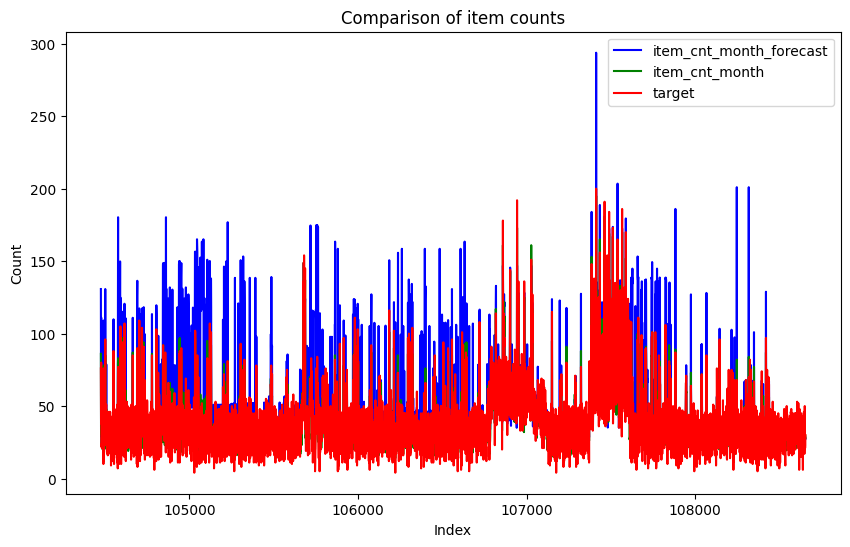

In [56]:
import matplotlib.pyplot as plt

# Tạo một biểu đồ mới
plt.figure(figsize=(10, 6))

# Vẽ đường cho cột 'item_cnt_month_forecast'
plt.plot(X_test.index, X_test['item_cnt_month_forecast'], label='item_cnt_month_forecast', color='blue')

# Vẽ đường cho cột 'item_cnt_month'
plt.plot(X_test.index, X_test['item_cnt_month'], label='item_cnt_month', color='green')

# Vẽ đường cho cột 'target'
plt.plot(X_test.index, X_test['target'], label='target', color='red')

# Đặt tiêu đề cho biểu đồ
plt.title('Comparison of item counts')

# Đặt nhãn cho trục x và trục y
plt.xlabel('Index')
plt.ylabel('Count')

# Thêm chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()


In [57]:
df=X_test

In [58]:
df

,date_block_num,campaign_id,product_id,profit_month,name,short_description,categories_id,categories_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,product_avg_sale_last_6,product_std_sale_last_6,product_avg_sale_last_12,product_std_sale_last_12,campaign_avg_sale_last_6,campaign_std_sale_last_6,campaign_avg_sale_last_12,campaign_std_sale_last_12,category_avg_sale_last_12,category_std_sale_last_12,date_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_2,date_campaign_avg_item_cnt_lag_3,date_campaign_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_campaign_cat_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_last_sale,item_campaign_first_sale,item_first_sale,item_cnt_month_forecast,item_cnt_month,target
104475,26,1,42899542,430000,1098,1005,10378,55,105.0,89.0,101.0,420.0,3.096221,5.194885,3.904368,4.602506,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.250000,160.500000,99.000000,87.687500,102.312500,418.000000,84.62500,0.000000,0.098877,2,2,25.0,25,25,130.760559,86,76
104476,26,1,61393910,155000,896,925,1685,59,35.0,32.0,26.0,131.0,1.039471,1.738017,1.347013,1.638383,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,35.656250,32.000000,29.671875,140.000000,37.87500,0.000000,0.098877,2,2,25.0,25,25,29.155863,31,38
104477,26,1,68202834,3700000,121,1052,10378,55,96.0,87.0,92.0,447.0,3.176809,5.506434,3.999085,4.806958,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.250000,160.500000,93.312500,89.312500,97.687500,438.250000,84.62500,0.000000,0.098877,2,2,25.0,25,25,111.033714,74,80
104478,26,1,73552136,155000,9,1061,1685,59,25.0,29.0,28.0,130.0,1.002096,1.732555,1.289802,1.566913,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,28.000000,29.328125,27.671875,138.000000,37.87500,0.000000,0.098877,2,2,25.0,25,25,29.155863,31,25
104479,26,1,74421745,155000,1032,1098,1685,59,38.0,35.0,33.0,119.0,0.992753,1.589500,1.312686,1.534918,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,30.328125,34.000000,33.000000,130.000000,37.87500,0.099731,0.098877,2,2,25.0,25,25,29.155863,31,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108649,26,48,273386993,1600000,293,225,49642,8,31.0,27.0,30.0,33.0,0.668064,0.107747,0.694802,0.093081,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,33.656250,26.328125,32.000000,32.656250,32.59375,0.000000,0.029602,2,2,25.0,25,25,32.697990,32,50
108650,26,48,273633499,1300000,256,661,49642,8,31.0,27.0,34.0,33.0,0.606163,0.067887,0.687174,0.058290,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,27.671875,27.671875,31.671875,30.328125,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.326887,26,27
108651,26,48,273847739,1500000,903,952,49642,8,31.0,37.0,27.0,26.0,0.636530,0.140311,0.701795,0.087723,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,33.343750,28.328125,26.000000,27.328125,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.764393,30,21
108652,26,48,274069973,1450000,291,0,49642,8,37.0,29.0,28.0,37.0,0.669232,0.077699,0.699887,0.075482,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,32.656250,29.328125,31.671875,34.000000,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.404255,29,23


In [59]:
def calculate_salary(row):
    if row['item_cnt_month'] < 100:
        return row['profit_month'] * 0.5
    elif 100 <= row['item_cnt_month'] < 200:
        return row['profit_month'] * 0.52
    elif 200 <= row['item_cnt_month'] < 500:
        return row['profit_month'] * 0.55
    else:
        return row['profit_month'] * 0.6

df['salary'] = df.apply(calculate_salary, axis=1)
df

,date_block_num,campaign_id,product_id,profit_month,name,short_description,categories_id,categories_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,product_avg_sale_last_6,product_std_sale_last_6,product_avg_sale_last_12,product_std_sale_last_12,campaign_avg_sale_last_6,campaign_std_sale_last_6,campaign_avg_sale_last_12,campaign_std_sale_last_12,category_avg_sale_last_12,category_std_sale_last_12,date_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_2,date_campaign_avg_item_cnt_lag_3,date_campaign_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_campaign_cat_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_last_sale,item_campaign_first_sale,item_first_sale,item_cnt_month_forecast,item_cnt_month,target,salary
104475,26,1,42899542,430000,1098,1005,10378,55,105.0,89.0,101.0,420.0,3.096221,5.194885,3.904368,4.602506,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.250000,160.500000,99.000000,87.687500,102.312500,418.000000,84.62500,0.000000,0.098877,2,2,25.0,25,25,130.760559,86,76,215000.0
104476,26,1,61393910,155000,896,925,1685,59,35.0,32.0,26.0,131.0,1.039471,1.738017,1.347013,1.638383,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,35.656250,32.000000,29.671875,140.000000,37.87500,0.000000,0.098877,2,2,25.0,25,25,29.155863,31,38,77500.0
104477,26,1,68202834,3700000,121,1052,10378,55,96.0,87.0,92.0,447.0,3.176809,5.506434,3.999085,4.806958,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.250000,160.500000,93.312500,89.312500,97.687500,438.250000,84.62500,0.000000,0.098877,2,2,25.0,25,25,111.033714,74,80,1850000.0
104478,26,1,73552136,155000,9,1061,1685,59,25.0,29.0,28.0,130.0,1.002096,1.732555,1.289802,1.566913,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,28.000000,29.328125,27.671875,138.000000,37.87500,0.000000,0.098877,2,2,25.0,25,25,29.155863,31,25,77500.0
104479,26,1,74421745,155000,1032,1098,1685,59,38.0,35.0,33.0,119.0,0.992753,1.589500,1.312686,1.534918,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.250000,160.500000,30.328125,34.000000,33.000000,130.000000,37.87500,0.099731,0.098877,2,2,25.0,25,25,29.155863,31,22,77500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108649,26,48,273386993,1600000,293,225,49642,8,31.0,27.0,30.0,33.0,0.668064,0.107747,0.694802,0.093081,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,33.656250,26.328125,32.000000,32.656250,32.59375,0.000000,0.029602,2,2,25.0,25,25,32.697990,32,50,800000.0
108650,26,48,273633499,1300000,256,661,49642,8,31.0,27.0,34.0,33.0,0.606163,0.067887,0.687174,0.058290,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,27.671875,27.671875,31.671875,30.328125,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.326887,26,27,650000.0
108651,26,48,273847739,1500000,903,952,49642,8,31.0,37.0,27.0,26.0,0.636530,0.140311,0.701795,0.087723,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,33.343750,28.328125,26.000000,27.328125,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.764393,30,21,750000.0
108652,26,48,274069973,1450000,291,0,49642,8,37.0,29.0,28.0,37.0,0.669232,0.077699,0.699887,0.075482,0.537633,0.026420,0.581802,0.024610,1.024833,0.040937,106.1875,31.4375,31.7500,30.015625,31.671875,32.656250,29.328125,31.671875,34.000000,32.59375,0.000000,0.029602,2,2,25.0,25,25,28.404255,29,23,725000.0


In [60]:
df_campaign_1 = df.loc[df['campaign_id'] == 1]
df_campaign_1

,date_block_num,campaign_id,product_id,profit_month,name,short_description,categories_id,categories_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,product_avg_sale_last_6,product_std_sale_last_6,product_avg_sale_last_12,product_std_sale_last_12,campaign_avg_sale_last_6,campaign_std_sale_last_6,campaign_avg_sale_last_12,campaign_std_sale_last_12,category_avg_sale_last_12,category_std_sale_last_12,date_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_1,date_campaign_avg_item_cnt_lag_2,date_campaign_avg_item_cnt_lag_3,date_campaign_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_campaign_cat_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_last_sale,item_campaign_first_sale,item_first_sale,item_cnt_month_forecast,item_cnt_month,target,salary
104475,26,1,42899542,430000,1098,1005,10378,55,105.0,89.0,101.0,420.0,3.096221,5.194885,3.904368,4.602506,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.25,160.5,99.000000,87.687500,102.312500,418.0000,84.6250,0.000000,0.098877,2,2,25.0,25,25,130.760559,86,76,215000.0
104476,26,1,61393910,155000,896,925,1685,59,35.0,32.0,26.0,131.0,1.039471,1.738017,1.347013,1.638383,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.25,160.5,35.656250,32.000000,29.671875,140.0000,37.8750,0.000000,0.098877,2,2,25.0,25,25,29.155863,31,38,77500.0
104477,26,1,68202834,3700000,121,1052,10378,55,96.0,87.0,92.0,447.0,3.176809,5.506434,3.999085,4.806958,1.546094,2.729624,1.972577,2.380269,0.795596,0.964616,106.1875,35.6875,34.9375,34.25,160.5,93.312500,89.312500,97.687500,438.2500,84.6250,0.000000,0.098877,2,2,25.0,25,25,111.033714,74,80,1850000.0
104478,26,1,73552136,155000,9,1061,1685,59,25.0,29.0,28.0,130.0,1.002096,1.732555,1.289802,1.566913,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.25,160.5,28.000000,29.328125,27.671875,138.0000,37.8750,0.000000,0.098877,2,2,25.0,25,25,29.155863,31,25,77500.0
104479,26,1,74421745,155000,1032,1098,1685,59,38.0,35.0,33.0,119.0,0.992753,1.589500,1.312686,1.534918,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.25,160.5,30.328125,34.000000,33.000000,130.0000,37.8750,0.099731,0.098877,2,2,25.0,25,25,29.155863,31,22,77500.0
104480,26,1,75329276,110000,1040,1104,5333,58,26.0,28.0,33.0,144.0,1.035967,1.803509,1.301244,1.530410,1.546094,2.729624,1.972577,2.380269,1.876826,2.297801,106.1875,35.6875,34.9375,34.25,160.5,27.671875,31.000000,31.671875,143.3750,28.9375,0.000000,0.098877,2,2,25.0,25,25,23.381355,22,24,55000.0
104481,26,1,75329760,150000,961,284,5333,58,33.0,35.0,29.0,159.0,1.024287,1.802207,1.334300,1.644917,1.546094,2.729624,1.972577,2.380269,1.876826,2.297801,106.1875,35.6875,34.9375,34.25,160.5,32.000000,32.000000,27.000000,142.6250,28.9375,0.000000,0.098877,2,2,25.0,25,25,28.764393,30,21,75000.0
104482,26,1,76091452,170000,1272,701,1685,59,41.0,28.0,35.0,141.0,1.074509,1.661806,1.342563,1.576973,1.546094,2.729624,1.972577,2.380269,2.893949,3.497659,106.1875,35.6875,34.9375,34.25,160.5,36.343750,29.000000,35.000000,137.6250,37.8750,0.002853,0.098877,2,2,25.0,25,25,31.772161,34,38,85000.0
104483,26,1,76695833,115000,1083,321,5333,58,21.0,36.0,24.0,144.0,1.028959,1.882043,1.333028,1.603296,1.546094,2.729624,1.972577,2.380269,1.876826,2.297801,106.1875,35.6875,34.9375,34.25,160.5,26.671875,30.000000,26.671875,147.0000,28.9375,0.000000,0.098877,2,2,25.0,25,25,23.816744,23,28,57500.0
104484,26,1,76705126,145000,1293,35,5333,58,31.0,30.0,31.0,133.0,1.037135,1.723461,1.308872,1.523244,1.546094,2.729624,1.972577,2.380269,1.876826,2.297801,106.1875,35.6875,34.9375,34.25,160.5,26.328125,29.000000,32.000000,139.0000,28.9375,0.000000,0.098877,2,2,25.0,25,25,28.404255,29,48,72500.0


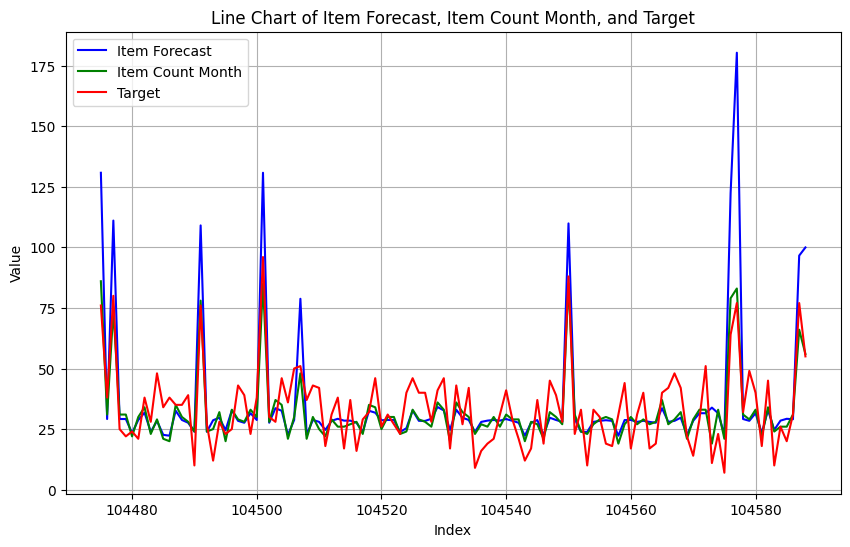

In [61]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ đường cho cột "item_cnt_month_forecast"
plt.plot(df_campaign_1.index, df_campaign_1['item_cnt_month_forecast'], label='Item Forecast', linestyle='-', color='blue')

# Vẽ đường cho cột "item_cnt_month"
plt.plot(df_campaign_1.index, df_campaign_1['item_cnt_month'], label='Item Count Month', linestyle='-', color='green')

# Vẽ đường cho cột "target"
plt.plot(df_campaign_1.index, df_campaign_1['target'], label='Target', linestyle='-', color='red')

# Đặt tên trục và tiêu đề
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Chart of Item Forecast, Item Count Month, and Target')

# Thêm chú thích và lưới
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


In [62]:
df2=df.groupby(['product_id']).agg({'item_cnt_month': ['sum']})
df2.columns = [ 'order_ctn_month']
df2

,order_ctn_month
product_id,
2001819,86
2525605,70
2598757,78
2731793,86
3714775,95
...,...
274070205,85
274567901,173
274780231,165


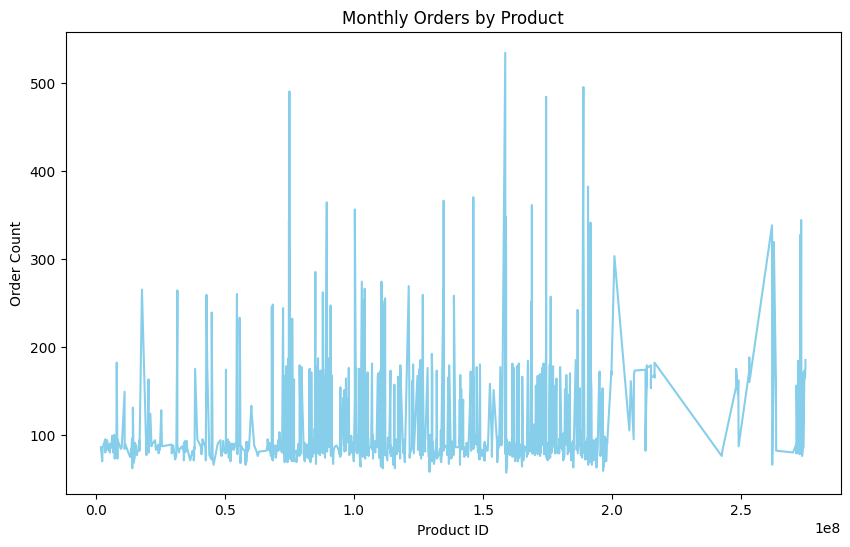

In [63]:
import matplotlib.pyplot as plt

# Tạo biểu đồ dạng đường
plt.figure(figsize=(10, 6))
plt.plot(df2.index, df2['order_ctn_month'], color='skyblue')

# Đặt tiêu đề và nhãn cho biểu đồ
plt.title('Monthly Orders by Product')
plt.xlabel('Product ID')
plt.ylabel('Order Count')

# Hiển thị biểu đồ
plt.show()


In [ ]:
# sum_order_ctn_month = df2['order_ctn_month'].sum()
# print("Tổng số đơn hàng trong tháng 2:", sum_order_ctn_month)

In [ ]:
# product_data_1 = df2.loc[df2['order_ctn_month'] < 100]
# product_data_1

In [ ]:
# product_data_2 = df2.loc[(df2['order_ctn_month'] >= 100) & (df2['order_ctn_month'] < 500)]

# product_data_2

In [ ]:
# product_data_2 = df2.loc[(df2['order_ctn_month'] >= 500)]

# product_data_2

In [ ]:
# df1 = df.groupby(['campaign_id']).agg({'profit_month': ['sum'], 'salary': ['sum']})

# # Đặt lại tên cột kết quả
# df1.columns = [ 'profit_month_sum','salary_month_sum']
# df1

In [ ]:
# marketing  = pd.read_csv('E:/DOWLOAD/LightGBM_XGBoost/data/marketing.csv')

In [ ]:
# marketing

In [ ]:
# # Thực hiện phép nối giữa DataFrame 'matrix' và DataFrame 'items' dựa trên cột 'product_id' của 'matrix' và cột 'id' của 'items'
# marketing = pd.merge(marketing, df1, left_on=['ID'], right_on=['campaign_id'], how='left')

# # Xóa cột 'id' trong DataFrame 'matrix' nếu bạn không cần nó sau khi đã thực hiện phép nối
# marketing.drop('ID', axis=1, inplace=True)

In [ ]:
# marketing

In [ ]:
# marketing['profit_month']=marketing['profit_month_sum']-29*marketing['Marketing_Cost_Day']

In [ ]:
# marketing.drop(['profit_month_sum'], axis=1, inplace=True)

In [ ]:
# marketing

In [ ]:
# # Lọc ra các dòng có giá trị âm trong cột profit_month
# negative_profit_data = marketing.loc[marketing['profit_month'] < 0]

# # Lưu DataFrame chứa dữ liệu có profit_month âm vào một tệp tin CSV mới
# negative_profit_data.to_csv("marketing_fail.csv", index=False)

In [ ]:
# negative_profit_data

In [ ]:
# expensive  = pd.read_csv('E:/DOWLOAD/LightGBM_XGBoost/data/expensive.csv')
# salary= pd.read_csv('E:/DOWLOAD/LightGBM_XGBoost/data/salary.csv')

In [ ]:
# # Tính tổng của cột profit_month
# total_profit = marketing['profit_month'].sum() -expensive['Chi phí (VNĐ)'].sum() -sum_order_ctn_month*1000- marketing['salary_month_sum'].sum()

# # In ra tổng lợi nhuận
# print("Tổng lợi nhuận trước thuế: ", total_profit)